# Lista 4 - Lista 3 - Processamento Adaptativos de Sinais - COE718
## Alexandre Henrique da Silva Nunes

In [2]:
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
from scipy import signal

Utilidades

In [3]:
def tapped_x(x, window, k):
    """
    Take a long row vector and return mirrored sub row vector starting from k-window to k.
    Returns 0 for all negative index

    Inputs
    -------

    x : numpy array (row vector)
    input signal to feed filter
    window : integer
    sub x vector length.
    k : integer
    sub x vector last index

    Outputs
    -------

    tapped_x : mirrored sub row vector
    """

    prefixed_input = _range_x(x, k-window+1, k+1)
    return prefixed_input[::-1]

def dim_x(vec):
    """
    Take an vector and return number of rows or array length.

    Inputs
    -------

    vec : numpy array (row vector)

    Outputs
    -------

    dim : integer
    number of rows or array length.
    """

    return vec.shape[0]

def conj(vec):
    """
    Take an complex vector and return its conjugate.

    Inputs
    -------

    vec : numpy array (row vector)

    Outputs
    -------

    conj_vec : numpy array (row vector)
    conjugated vector
    """
    return np.conjugate(vec)

def _x(x, index):
    if index < 0:
        if x.dtype == complex: return complex(0, 0)
        return 0;
    return x[index]

# Improve source code regularity
def _range_x(x, start, length):
    sub_x = [_x(x, start)]
    for it in range(start+1, length):
        sub_x = np.append(sub_x, _x(x, it))
    return sub_x

## Questão 4.8
### Item a

Algoritmo sign error implemetado

In [69]:
class SignError:
    """
    Description
    ---------
    Author: Alexandre Henrique da Silva Nunes
    Based on Matlab code by Markus Vinícius Santos Lima available at 
    https://www.mathworks.com/matlabcentral/fileexchange/3582-adaptive-filtering
    
    Implements the REAL Sign Error LMS-based algorithm for REAL valued data.
    (Algorithm 4.1 - book: Adaptive Filtering: Algorithms and Practical Implementation, Diniz)
    
    Methods
    ---------
    fit :
        update filter params based on a desired signal and inputs.
    """
    
    def __init__(self, filter_order_num, initial_coefficients):
        """
        Inputs
        -------
        
        filter_order_num : int
                    Order of the FIR filter
        initial_coefficients : numpy array (collumn vector)
                    initial filter coefficients
                
                    
        Variables
        --------
        num_of_coefficients : int
            FIR filter number of coefficients.
        
        errors_vector : numpy array
            FIR error vectors. error_vector[k] represents the output erros at iteration k.
        outputs_vector : numpy array (collumn vector)
            Store the estimated output of each iteration. outputs_vector[k] represents the output erros at iteration k
        coefficients_mtx : numpy array
            Store the estimated coefficients for each iteration. (Coefficients at one iteration are COLUMN vector)
        """
        
        self.filter_order_num = filter_order_num
        self.num_of_coefficients = self.filter_order_num + 1
        
        self.errors_vector = np.array([0], dtype=initial_coefficients.dtype)
        self.outputs_vector = np.array([0], dtype=initial_coefficients.dtype)
        self.coefficients_mtx = np.array(initial_coefficients, dtype=initial_coefficients.dtype)
        
    def fit(self, desired, x, step):
        """
        Fit filter parameters to considering desired vector and input x. desired and x must have length K,
        where K is the number of iterations
        
        Inputs
        -------
        
        desired : numpy array (row vector)
            desired signal
        x : numpy array (row vector)
            input signal to feed filter
        step : Convergence (relaxation) factor.
        kargs: Algorithm particular arguments. See each class for more info.
        
        Outputs
        -------
        
        python dic :
            outputs : numpy array (collumn vector)
                Store the estimated output of each iteration. outputs_vector[k] represents the output erros at iteration k
            errors : numpy array (collumn vector)
                FIR error vectors. error_vector[k] represents the output erros at iteration k.
            coefficients_mtx : numpy array
                Store the estimated coefficients for each iteration. (Coefficients at one iteration are COLUMN vector)      
        """
        
        k_max = dim_x(desired)
        self._initialize_vars(k_max)
        
        for k in range(k_max):
            x_k = tapped_x(x, self.num_of_coefficients, k)
            w_k = self.coefficients_mtx[:, k]
            y_k = np.dot(conj(w_k), x_k)
            err_k = desired[k] - y_k
        
            next_w_k = self._coefficients_update_function(w_k, step, err_k, x_k)
            
            self._update(err_k, y_k, next_w_k, k)
            
        return {
            'outputs': self.outputs_vector,
            'errors': self.errors_vector,
            'coefficients': self.coefficients_mtx
        }
        
    def _initialize_vars(self, k_max):
        self.errors_vector = np.zeros((k_max, 1))
        self.outputs_vector = np.zeros((k_max, 1), dtype=self.outputs_vector.dtype)
        
        initial_coefficients = self.coefficients_mtx[:, [0]]
        last_coefficients = np.zeros((self.num_of_coefficients, k_max), dtype=initial_coefficients.dtype)
        self.coefficients_mtx = np.append(initial_coefficients, last_coefficients, axis=1)
    
    def _update(self, err, y, next_w, k):
        self.errors_vector[k, 0] = err
        self.outputs_vector[k, 0] = y
        self.coefficients_mtx[:, k+1] = np.transpose(next_w)        
        
    def _coefficients_update_function(self, w_k, step, err_k, x_k):
        return w_k + 2 * step * np.sign(err_k) * x_k

Cálculo do traço da matriz

In [70]:
sigma_nx = 0.5
sigma_n = 1e-3
N = 11

def first_order_markov_r(a1, lag, var_n):
    return ((-a1) ** abs(lag))/(1 - a1 ** 2) * var_n

def tr_R_problem_8(N):
    return first_order_markov_r(0.9, 0, sigma_nx) * (N+1)

trR = tr_R_problem_8(N)
print('Traço de R: ', trR)

Traço de R:  31.578947368421062


Cálculo do $\mu_{max}$

In [71]:
def sign_error_mu_max(trR, err):
    return math.sqrt((math.pi * err)/2)/trR

In [72]:
mu_max = sign_error_mu_max(trR, sigma_n)
print('Passo máximo: ', mu_max)

Passo máximo:  0.0012550536442419032


### Item b

Configurando o problema

In [73]:
def generate_uniform_noise(kmax, var_n):
    regular_noise = np.random.uniform(-1, 1, kmax)
    return (regular_noise - regular_noise.mean())/np.sqrt(regular_noise.var()/var_n)

def generate_gaussian_noise(kmax, var_n):
    return np.random.normal(0, np.sqrt(var_n), size=kmax)

def generate_problem_8_x(kmax):
    sigma_nx = 0.5
    nx = generate_uniform_noise(kmax, sigma_nx)
    
    hin_a = [1, -0.9]
    hin_b = [1, 0]
    return signal.lfilter(hin_b, hin_a, nx)

def generate_problem_8_d(kmax, x):
    h_a = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    h_b = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
    
    sigma_n = 1e-3
    n = generate_gaussian_noise(kmax, sigma_n)
    
    d = signal.lfilter(h_b, h_a, x) + n
    
    return d, n

def problem_8_single_ensemble(kmax, step):
    x = generate_problem_8_x(kmax)
    d, n = generate_problem_8_d(kmax, x)
    N = 11
    w0 = np.zeros((N+1, 1))
    
    model = SignError(N, w0)
    result = model.fit(d, x, step)
    result['mse_min'] = np.square(n)
    
    return result
    

$\mu = \mu_{max}/2$

In [74]:
kmax = 50000
step = mu_max/2

def perform_problem_8_for_ensembles(kmax, step, ensembles):
    outputs_mean = 0
    errors_mean = 0
    coefficients_mean = 0
    mse_min_mean = 0
    
    for i in range(0, ensembles):
        result = problem_8_single_ensemble(kmax, step)
        outputs_mean += result['outputs']/ensembles
        errors_mean += result['errors']/ensembles
        coefficients_mean += result['coefficients']/ensembles
        mse_min_mean += result['mse_min']/ensembles
        
    return outputs_mean, errors_mean, coefficients_mean, mse_min_mean

ensembles = 25

outputs_mean, errors_mean, coefficients_mean, mse_min_mean = perform_problem_8_for_ensembles(kmax, step, ensembles)

In [75]:
def plot_and_save_mse(errors, save_path):
    fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)  
    ax.plot(np.linspace(1, kmax, kmax), 10 * np.log10(np.square(errors)), color='#1f77b4', linewidth=1)
    ax.grid(True)
    ax.set_xlabel('Iteração')
    ax.set_ylabel('MSE aproximado (dB)')
    ax.set_title('Evolução do Erro')
    fig.savefig(save_path, bbox_inches = 'tight')

def plot_and_save_coefficients(coeffs, save_path):
    fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
    for i in range(12):
        index = 12 - i
        ax.plot(np.linspace(1, kmax+1, kmax+1), coeffs[i, :], linewidth=1, label='$w_{%i}$' % index)
    ax.grid(True)
    ax.legend()
    ax.set_xlabel('Iteração')
    ax.set_ylabel('Coeficientes')
    ax.set_title('Evolução dos coeficientes')
    fig.savefig(save_path, bbox_inches = 'tight')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


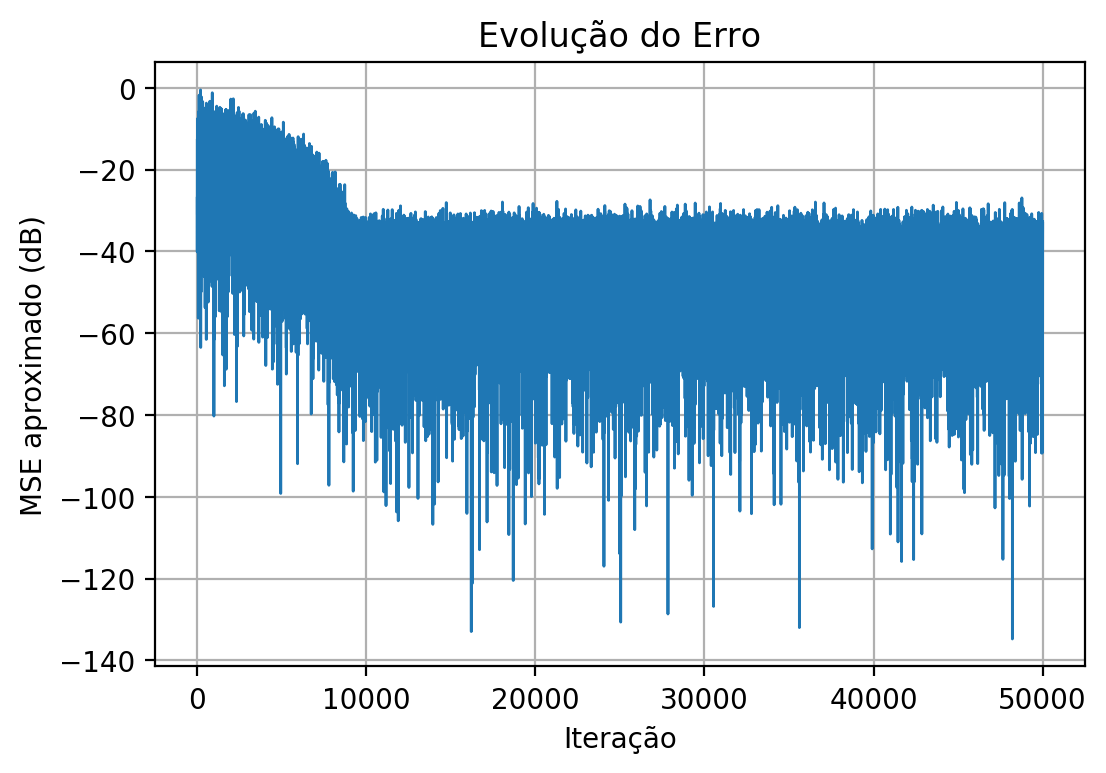

/usr/local/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


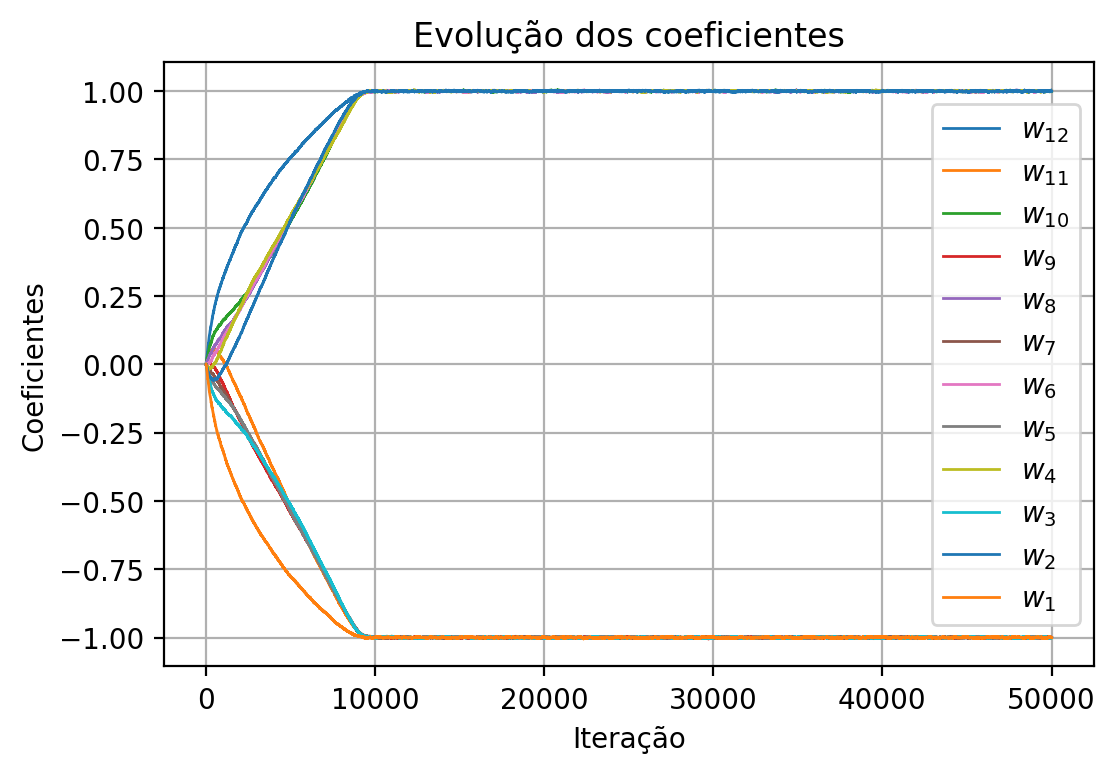

In [76]:
plot_and_save_mse(errors_mean, '../tex/images/lista3_8a1.pdf')
plot_and_save_coefficients(coefficients_mean, '../tex/images/lista3_8a2.pdf')

$\mu = \mu_{max}/5$

In [77]:
kmax = 50000
step = mu_max/5
ensembles = 25

outputs_mean2, errors_mean2, coefficients_mean2, mse_min_mean2 = perform_problem_8_for_ensembles(kmax, step, ensembles)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


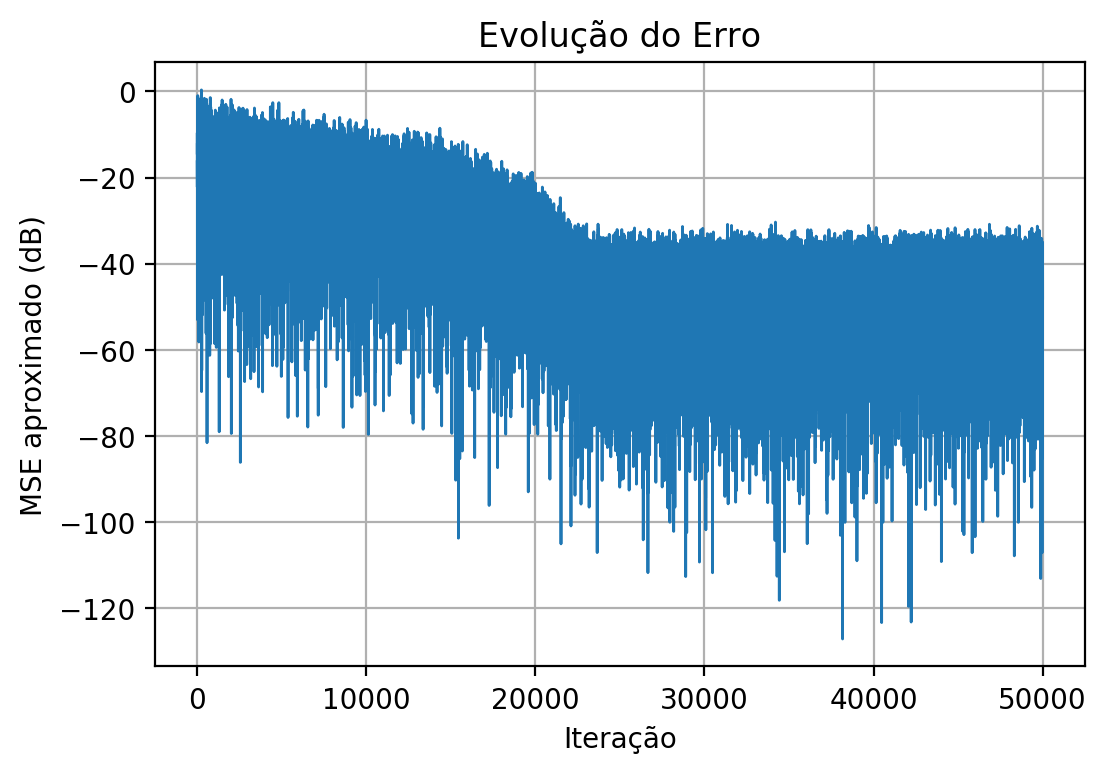

/usr/local/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


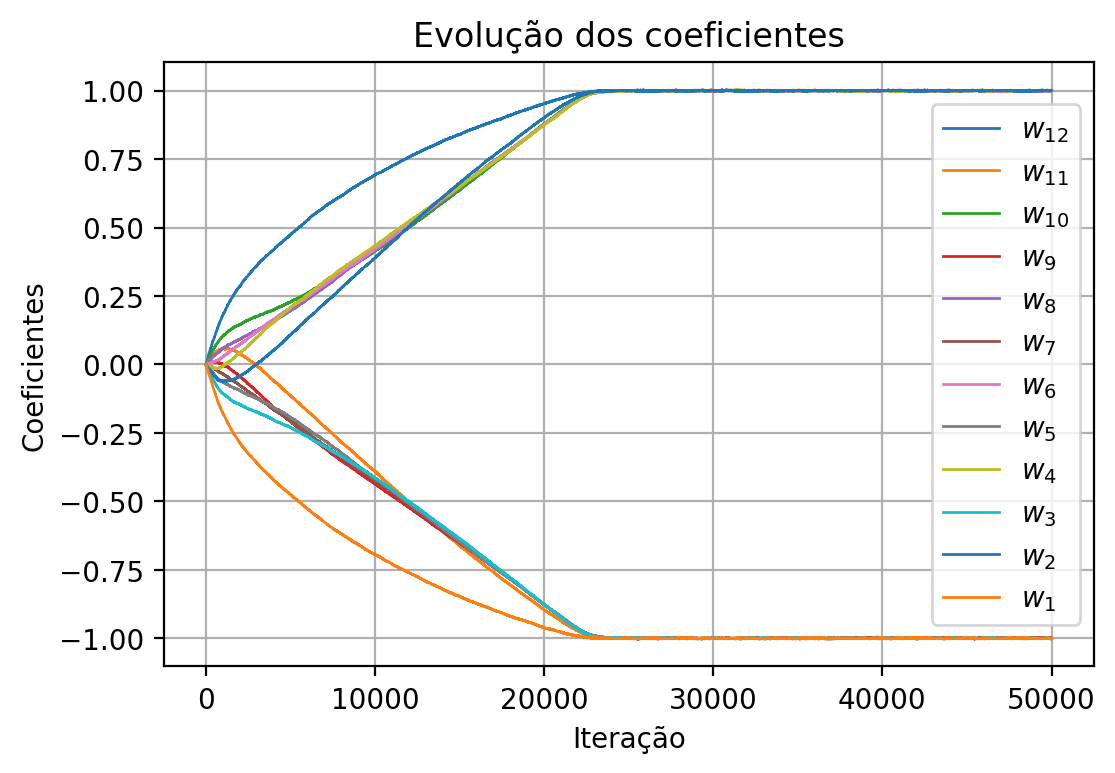

In [78]:
plot_and_save_mse(errors_mean2, '../tex/images/lista3_8a3.pdf')
plot_and_save_coefficients(coefficients_mean2, '../tex/images/lista3_8a4.pdf')

$\mu = \mu_{max}/10$

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


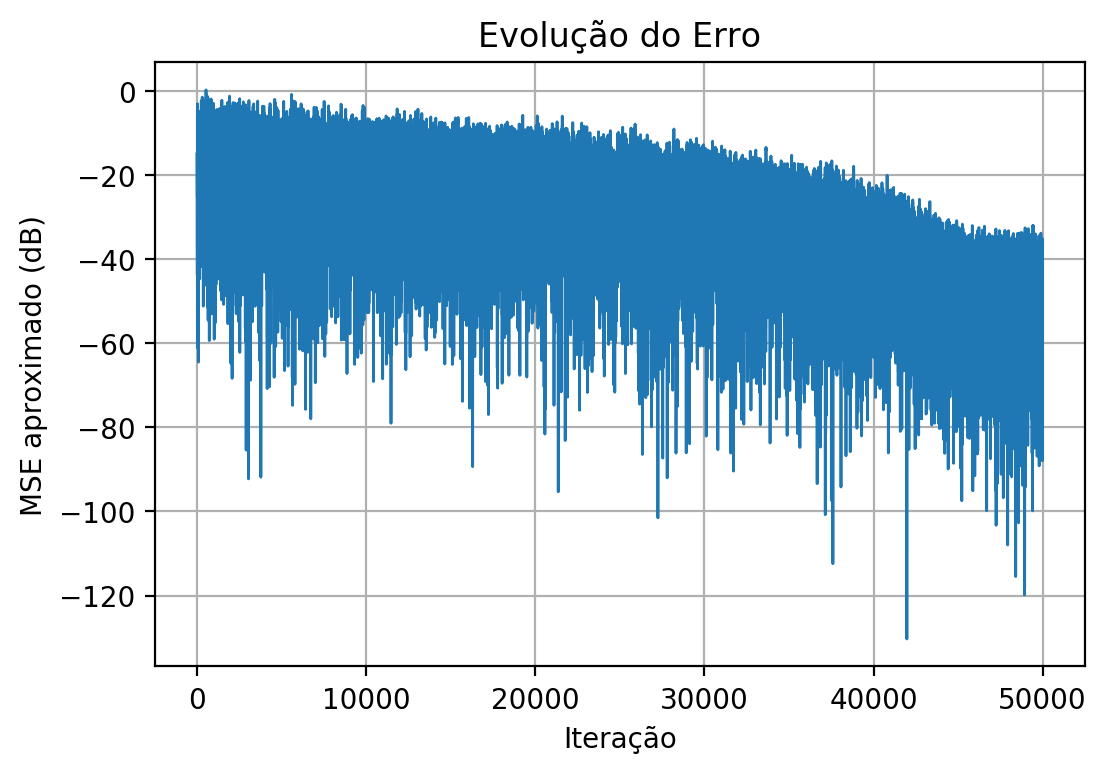

/usr/local/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


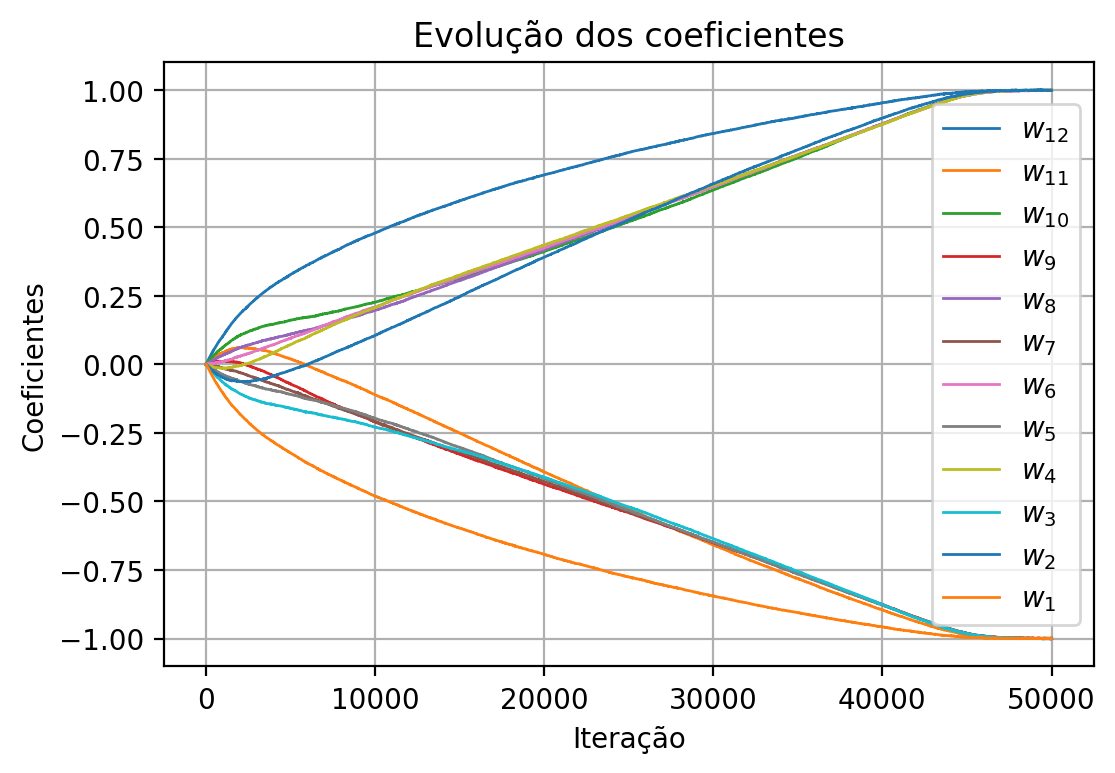

In [79]:
kmax = 50000
step = mu_max/10
ensembles = 25

outputs_mean3, errors_mean3, coefficients_mean3, mse_min_mean3 = perform_problem_8_for_ensembles(kmax, step, ensembles)
plot_and_save_mse(errors_mean3, '../tex/images/lista3_8a5.pdf')
plot_and_save_coefficients(coefficients_mean3, '../tex/images/lista3_8a6.pdf')

### Item c

In [80]:
def get_m_theo(mu):
    N = 11
    sigma_n = 1e-3
    xi_min = sigma_n
    trR = tr_R_problem_8(N)
    
    return mu * np.sqrt(math.pi/(2*xi_min)) * trR

Para $\mu=\mu_{max}/2$:

In [81]:
m_theo = get_m_theo(mu_max/2)
print('M teórico: ', m_theo)

M teórico:  0.7853981633974483


In [82]:
def get_m(errors, mse_min):
    mse = np.square(errors)
    m = np.zeros(mse.shape)
    for k in range(m.shape[0]):
        m[k] = (mse[k] - mse_min[k])/(mse_min[k])
    return m

def plot_and_save_misajustment(errors, mse_min, m_theo, save_path):
    fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
    m = get_m(errors, mse_min)
    
    ax.plot(np.linspace(1, kmax, kmax), m, color='#1f77b4', linewidth=1, label='Desajuste prático')
    ax.plot(np.linspace(1, kmax, kmax), m_theo*np.ones(kmax), color='#ff7f0e', linewidth=1, label='Desajuste Teórico (%0.2f)' % m_theo)
    ax.grid(True)
    ax.legend()
    ax.set_xlabel('Iteração')
    ax.set_ylabel('Desajuste')
    ax.set_title('Evolução do desajuste')
    fig.savefig(save_path, bbox_inches = 'tight')

Desajuste prático após convergência: -0.8962080396996366


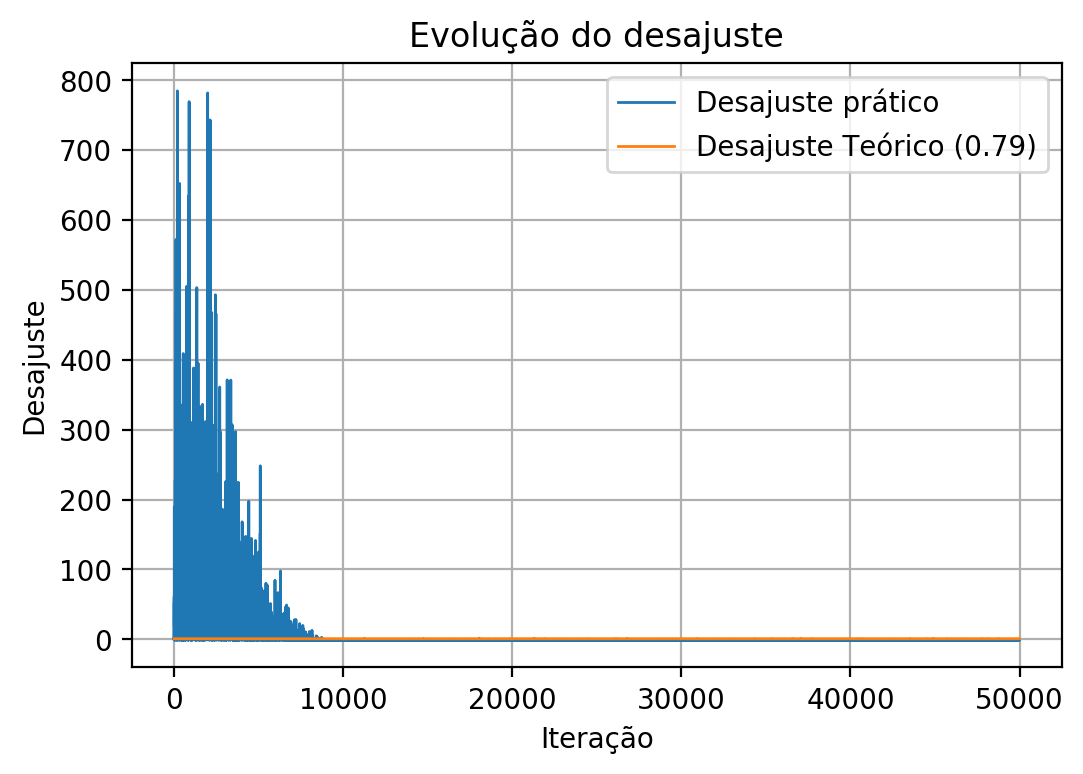

In [84]:
plot_and_save_misajustment(errors_mean, mse_min_mean, m_theo, '../tex/images/lista3_8a7.pdf')
m = get_m(errors_mean, mse_min_mean)

print('Desajuste prático após convergência:', np.mean(m[10000:]))

Para $\mu = \mu_{max}/5$:

In [85]:
m_theo2 = get_m_theo(mu_max/5)
print('M teórico: ', m_theo2)

M teórico:  0.3141592653589793


Desajuste prático após convergência: -0.9412697561179999


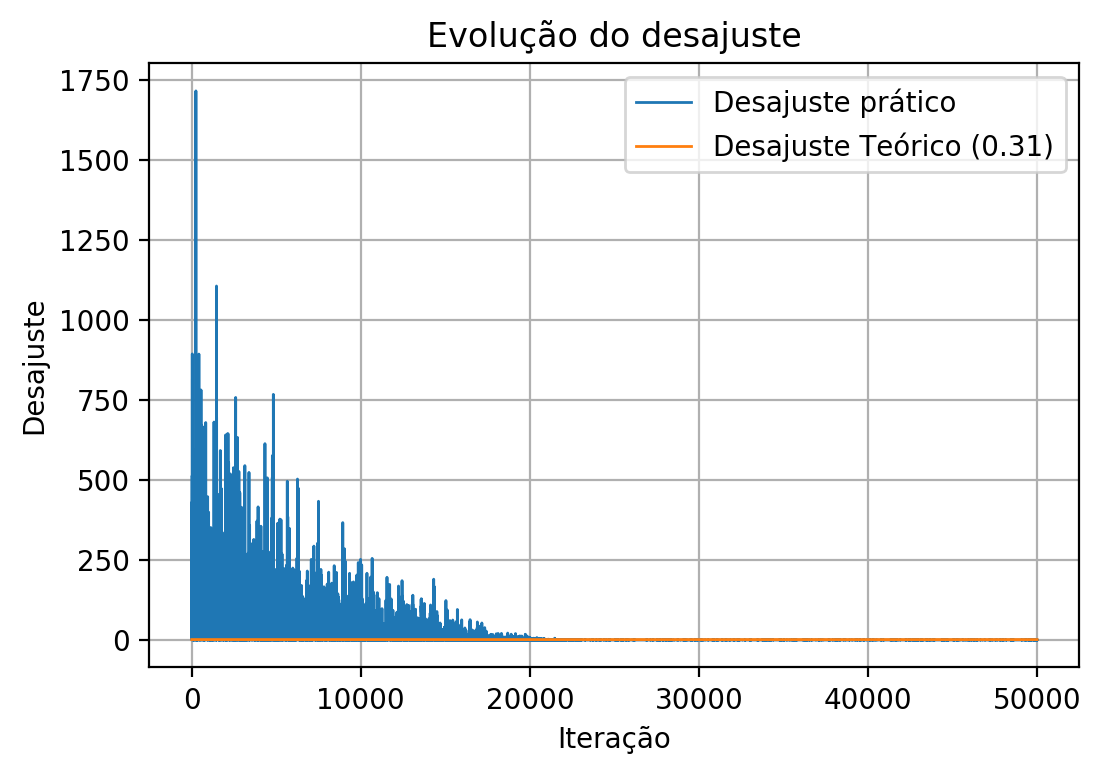

In [86]:
plot_and_save_misajustment(errors_mean2, mse_min_mean2, m_theo2, '../tex/images/lista3_8a8.pdf')
m2 = get_m(errors_mean2, mse_min_mean2)

print('Desajuste prático após convergência:', np.mean(m2[25000:]))

Para $\mu = \mu_{max}/10$:

In [87]:
m_theo3 = get_m_theo(mu_max/10)
print('M teórico: ', m_theo3)

M teórico:  0.15707963267948966


Desajuste prático após convergência: -0.9497916781075655


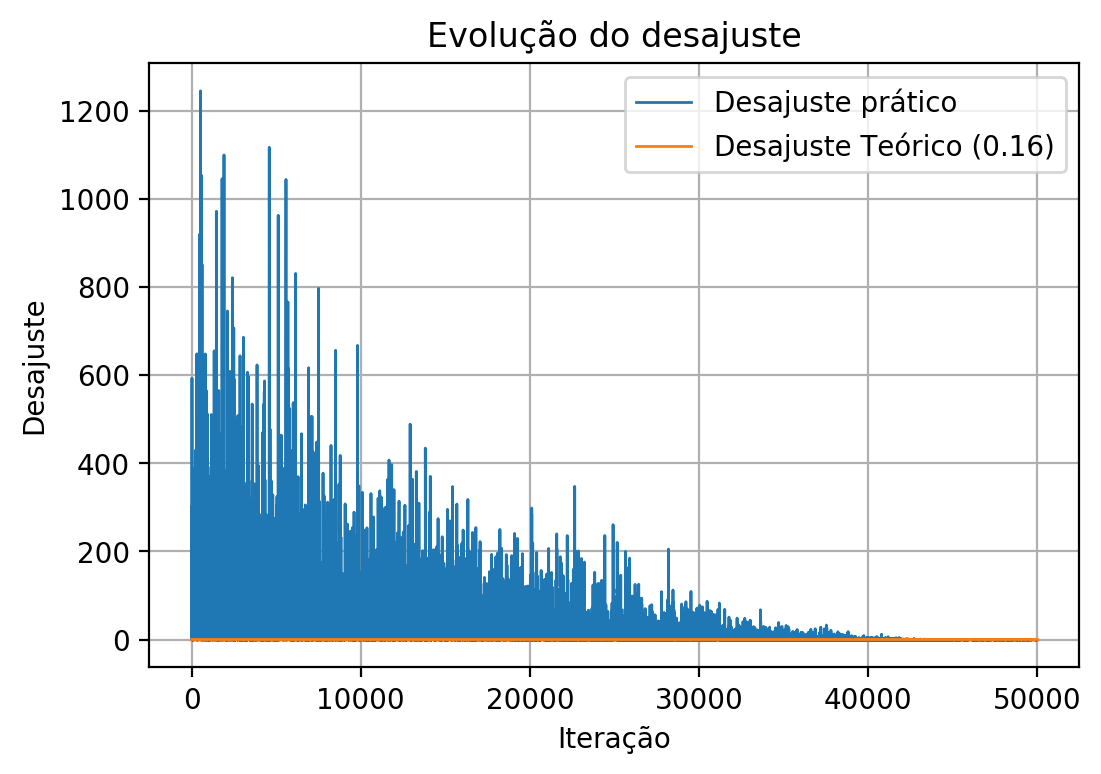

In [90]:
plot_and_save_misajustment(errors_mean3, mse_min_mean3, m_theo3, '../tex/images/lista3_8a9.pdf')
m3 = get_m(errors_mean3, mse_min_mean3)

print('Desajuste prático após convergência:', np.mean(m3[45000:]))

### Item d

In [91]:
def theo_freq_response_problem8():
    h_a = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    h_b = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]

    # wf_ref => Frequência
    # h_resp => Resposta em frequência
    wf_resp, h_resp = signal.freqz(h_b, a=h_a)
    return wf_resp, h_resp

def practice_freq_response_problem8(coeffs):
    wf_resp, h_resp = signal.freqz(coeffs[:, -1])
    return wf_resp, h_resp

def plot_and_savefreq_response_problem8(h_resp_theo, wf_resp_theo, h_resp_practice, wf_resp_practice, save_path):
    fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
    ax.plot(wf_resp_theo, 10 * np.log10(h_resp_theo + 0.1), 'r', label='Teórico')
    ax.plot(wf_resp_practice, 10 * np.log10(h_resp_practice + 0.1), label='Implementado', linestyle='--')
    ax.set_ylabel('Amplitude (dB)')
    ax.set_title('Resposta em frequência')
    ax.set_xlabel('Frequência (rad/amostra)')
    ax.grid(True)
    ax.legend()
    fig.savefig(save_path, bbox_inches = 'tight')

Para $\mu = \mu_{max}/2$:

/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


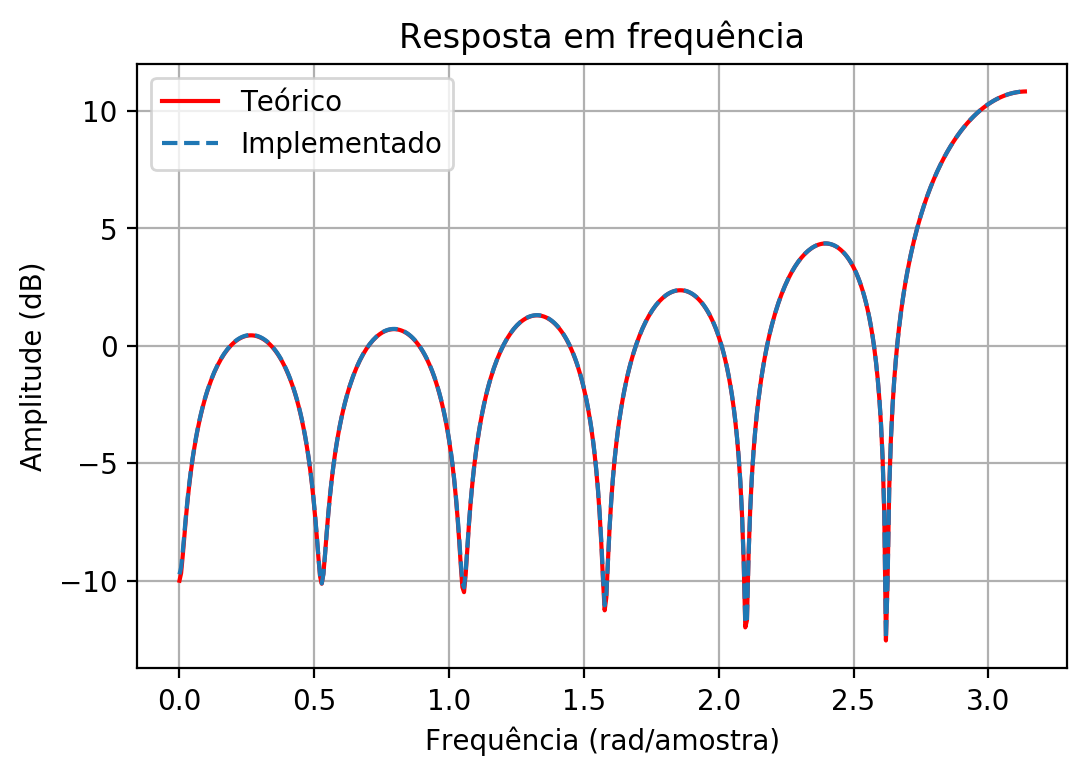

In [92]:
wf_resp_theo, h_resp_theo = theo_freq_response_problem8()
wf_resp_practice, h_resp_practice = practice_freq_response_problem8(coefficients_mean)

plot_and_savefreq_response_problem8(h_resp_theo, wf_resp_theo, h_resp_practice, wf_resp_practice, '../tex/images/lista3_8a10.pdf')


Para $\mu = \mu_{max}/5$:

/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


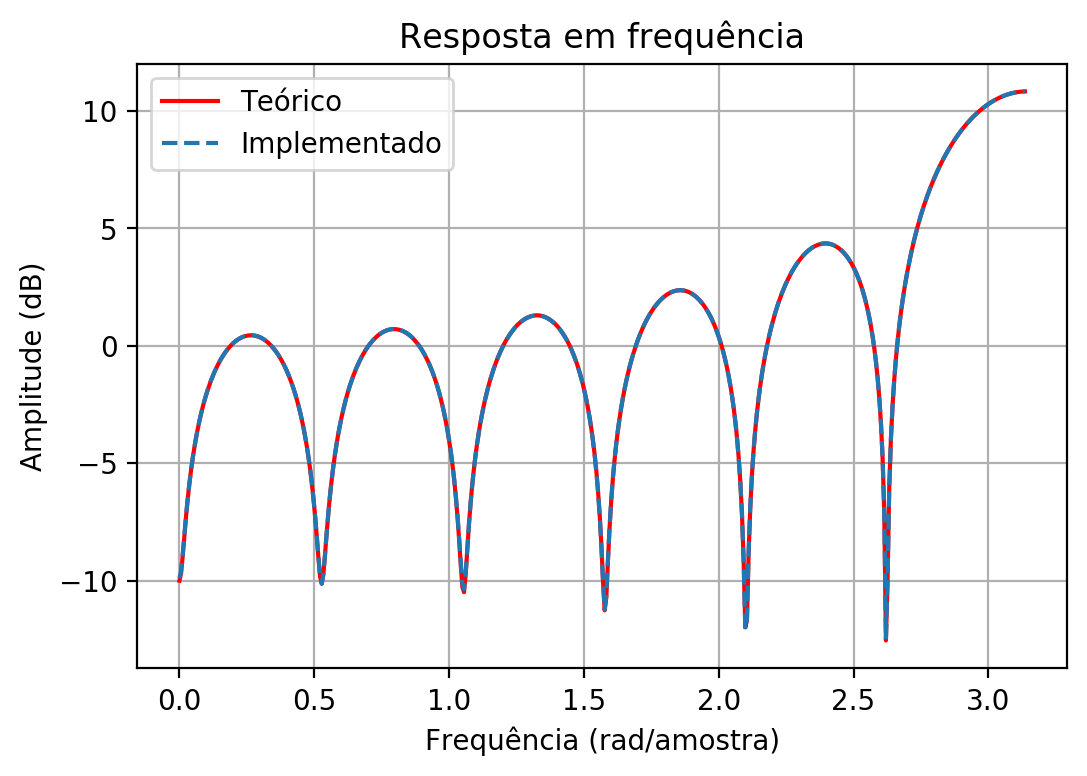

In [93]:
wf_resp_theo, h_resp_theo = theo_freq_response_problem8()
wf_resp_practice, h_resp_practice = practice_freq_response_problem8(coefficients_mean2)

plot_and_savefreq_response_problem8(h_resp_theo, wf_resp_theo, h_resp_practice, wf_resp_practice, '../tex/images/lista3_8a11.pdf')

Para $\mu = \mu_{max}/10$:

/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


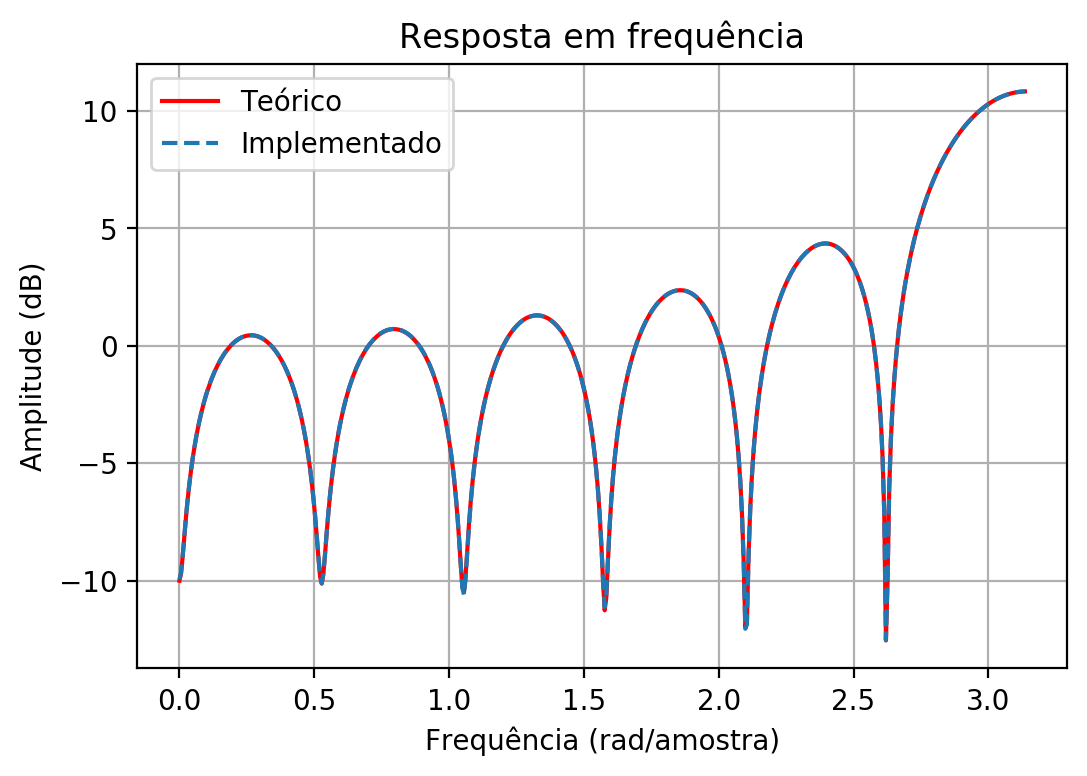

In [94]:
wf_resp_theo, h_resp_theo = theo_freq_response_problem8()
wf_resp_practice, h_resp_practice = practice_freq_response_problem8(coefficients_mean3)

plot_and_savefreq_response_problem8(h_resp_theo, wf_resp_theo, h_resp_practice, wf_resp_practice, '../tex/images/lista3_8a12.pdf')



## Questão 4.22

Algoritmo LMS Newton implementado

In [95]:
class LMSNewton:
    """
    Description
    ---------

    Implements the REAL LSM-Newton LMS-based algorithm for REAL valued data.
    (Algorithm 4.2 - book: Adaptive Filtering: Algorithms and Practical Implementation, Diniz)
    """
    def __init__(self, filter_order_num, initial_coefficients, initial_inv_estimate_R=None):
        """
        Inputs
        -------

        filter_order_num : int
                    Order of the FIR filter
        initial_coefficients : numpy array (collumn vector)
                    initial filter coefficients
        initial_inv_estimate_R : numpy array
                    initial inverse correlation matrix value. Default is eye matrix


        Variables
        --------
        num_of_coefficients : int
            FIR filter number of coefficients.

        errors_vector : numpy array
            FIR error vectors. error_vector[k] represents the output erros at iteration k.
        outputs_vector : numpy array (collumn vector)
            Store the estimated output of each iteration. outputs_vector[k] represents the output erros at iteration k
        coefficients_mtx : numpy array
            Store the estimated coefficients for each iteration. (Coefficients at one iteration are COLUMN vector)
        """

        self.filter_order_num = filter_order_num
        self.num_of_coefficients = self.filter_order_num + 1

        self.errors_vector = np.array([0], dtype=initial_coefficients.dtype)
        self.outputs_vector = np.array([0], dtype=initial_coefficients.dtype)
        self.coefficients_mtx = np.array(initial_coefficients, dtype=initial_coefficients.dtype)
        self.inv_estimate_R = initial_inv_estimate_R or np.eye(self.num_of_coefficients)

    def fit(self, desired, x, step, alpha):
        """
        Fit filter parameters to considering desired vector and input x. desired and x must have length K,
        where K is the number of iterations

        Inputs
        -------

        desired : numpy array (row vector)
            desired signal
        x : numpy array (row vector)
            input signal to feed filter
        step : float 
            convergence (relaxation) factor.
        alpha : float
            relaxion factor for calculate inverse of correlation matrix. Tipically 0 < alpha < 0.1

        Outputs
        -------

        python dic :
            outputs : numpy array (collumn vector)
                Store the estimated output of each iteration. outputs_vector[k] represents the output erros at iteration k
            errors : numpy array (collumn vector)
                FIR error vectors. error_vector[k] represents the output erros at iteration k.
            coefficients_mtx : numpy array
                Store the estimated coefficients for each iteration. (Coefficients at one iteration are COLUMN vector)      
        """

        k_max = dim_x(desired)
        self._initialize_vars(k_max)

        for k in range(k_max):
            x_k = tapped_x(x, self.num_of_coefficients, k)
            w_k = self.coefficients_mtx[:, k]
            y_k = np.dot(conj(w_k), x_k)
            err_k = desired[k] - y_k

            next_w_k = self._coefficients_update_function(w_k, err_k, x_k, step, alpha)

            self._update(err_k, y_k, next_w_k, k)

        return {
            'outputs': self.outputs_vector,
            'errors': self.errors_vector,
            'coefficients': self.coefficients_mtx
        }

    def _coefficients_update_function(self, w_k, err_k, x_k, step, alpha):
        """
        Input
        ---------
        kargs alpha : float number
          Usually between 0 and 0.1. Used to estimate the correlation matrix and its inverse.
        """
        prod_a = np.dot(self.inv_estimate_R, np.transpose(np.array([x_k])))
        prod_b = np.dot(np.transpose(np.conj(x_k)), self.inv_estimate_R)
        num = np.dot(prod_a, np.array([prod_b]))
        den = (1 - alpha)/alpha + np.dot(np.dot(np.conj(x_k), self.inv_estimate_R), x_k)

        next_w_k = w_k + step * err_k * np.dot(self.inv_estimate_R, x_k)
        self.update_inv_estimate_R(alpha, num, den)

        return next_w_k

    def _initialize_vars(self, k_max):
        self.errors_vector = np.zeros((k_max, 1))
        self.outputs_vector = np.zeros((k_max, 1), dtype=self.outputs_vector.dtype)

        initial_coefficients = self.coefficients_mtx[:, [0]]
        last_coefficients = np.zeros((self.num_of_coefficients, k_max), dtype=initial_coefficients.dtype)
        self.coefficients_mtx = np.append(initial_coefficients, last_coefficients, axis=1)

    def _update(self, err, y, next_w, k):
        self.errors_vector[k, 0] = err
        self.outputs_vector[k, 0] = y
        self.coefficients_mtx[:, k+1] = np.transpose(next_w)

    def update_inv_estimate_R(self, alpha, num, den):
        self.inv_estimate_R = 1/(1-alpha)*(self.inv_estimate_R - num/den)


In [96]:
trR = 31.58
mu_max = 1/trR
mu = 0.01

print('mu máximo:', mu_max)
print('mu adotado:', mu)

mu máximo: 0.031665611146295125
mu adotado: 0.01


In [97]:
def problem_22_single_ensemble(kmax, step, alpha):
    x = generate_problem_8_x(kmax) # same env
    d, n = generate_problem_8_d(kmax, x)
    N = 11
    w0 = np.zeros((N+1, 1))
    
    model = LMSNewton(N, w0)
    result = model.fit(d, x, step, alpha=alpha)
    result['mse_min'] = np.square(n)
    
    return result

In [98]:
def perform_problem_22_for_ensembles(kmax, step, alpha, ensembles):
    outputs_mean = 0
    errors_mean = 0
    coefficients_mean = 0
    mse_min_mean = 0
    
    for i in range(0, ensembles):
        result = problem_22_single_ensemble(kmax, step, alpha)
        outputs_mean += result['outputs']/ensembles
        errors_mean += result['errors']/ensembles
        coefficients_mean += result['coefficients']/ensembles
        mse_min_mean += result['mse_min']/ensembles
        
    return outputs_mean, errors_mean, coefficients_mean, mse_min_mean

kmax = 3000
ensembles = 25
step = 0.01
alpha = 0.01

outputs_mean4, errors_mean4, coefficients_mean4, mse_min_mean4 = perform_problem_22_for_ensembles(kmax, step, alpha, ensembles)

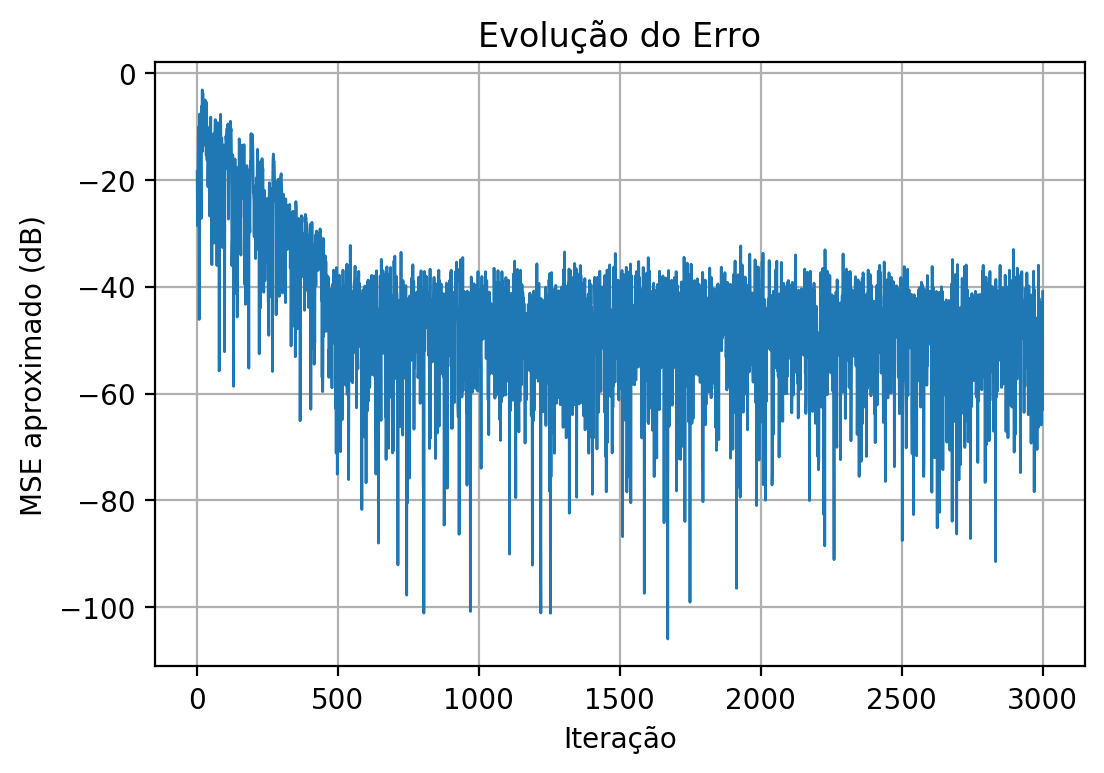

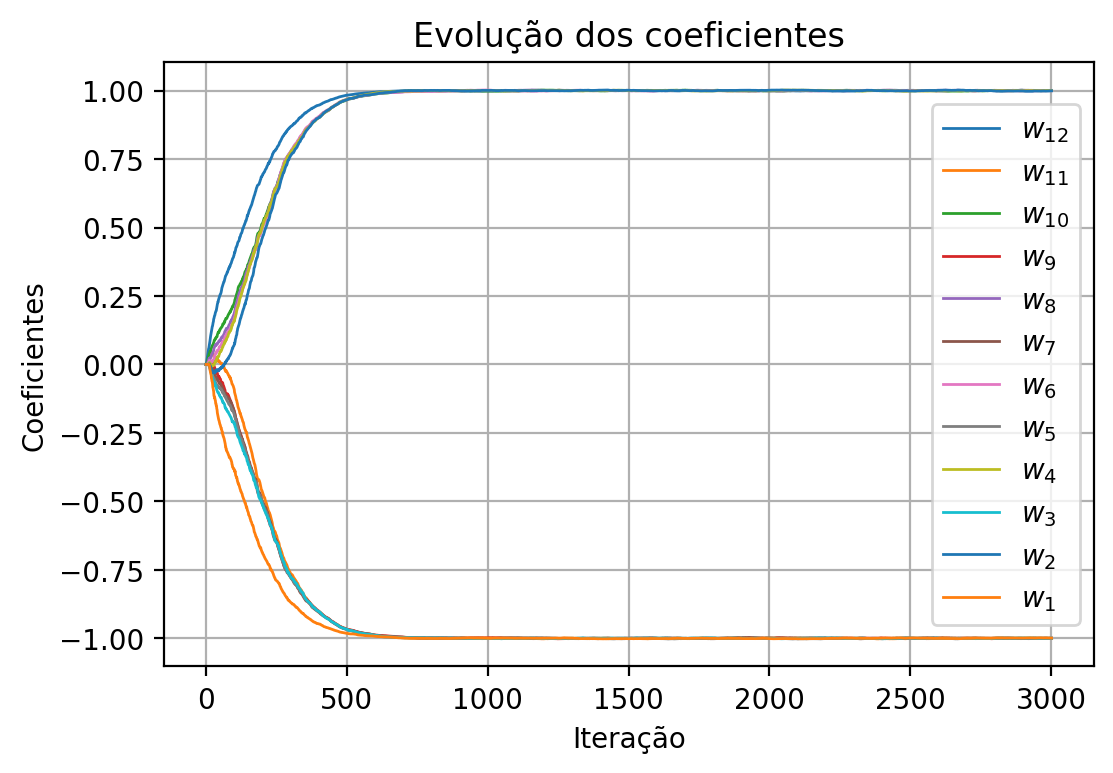

In [99]:
plot_and_save_mse(errors_mean4, '../tex/images/lista3_22a1.pdf')
plot_and_save_coefficients(coefficients_mean4, '../tex/images/lista3_22a2.pdf')

### Item a

In [100]:
def get_m(errors, mse_min):
    mse = np.square(errors)
    m = np.zeros(mse.shape)
    for k in range(m.shape[0]):
        m[k] = (mse[k] - mse_min[k])/(mse_min[k])
    return m

def plot_and_save_misajustment(errors, mse_min, save_path):
    fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
    m = get_m(errors, mse_min)
    
    ax.plot(np.linspace(1, kmax, kmax), m, color='#1f77b4', linewidth=1, label='Desajuste prático')
    ax.grid(True)
    ax.legend()
    ax.set_xlabel('Iteração')
    ax.set_ylabel('Desajuste')
    ax.set_title('Evolução do desajuste')
    fig.savefig(save_path, bbox_inches = 'tight')

Desajuste prático após convergência: -0.9557629721041696


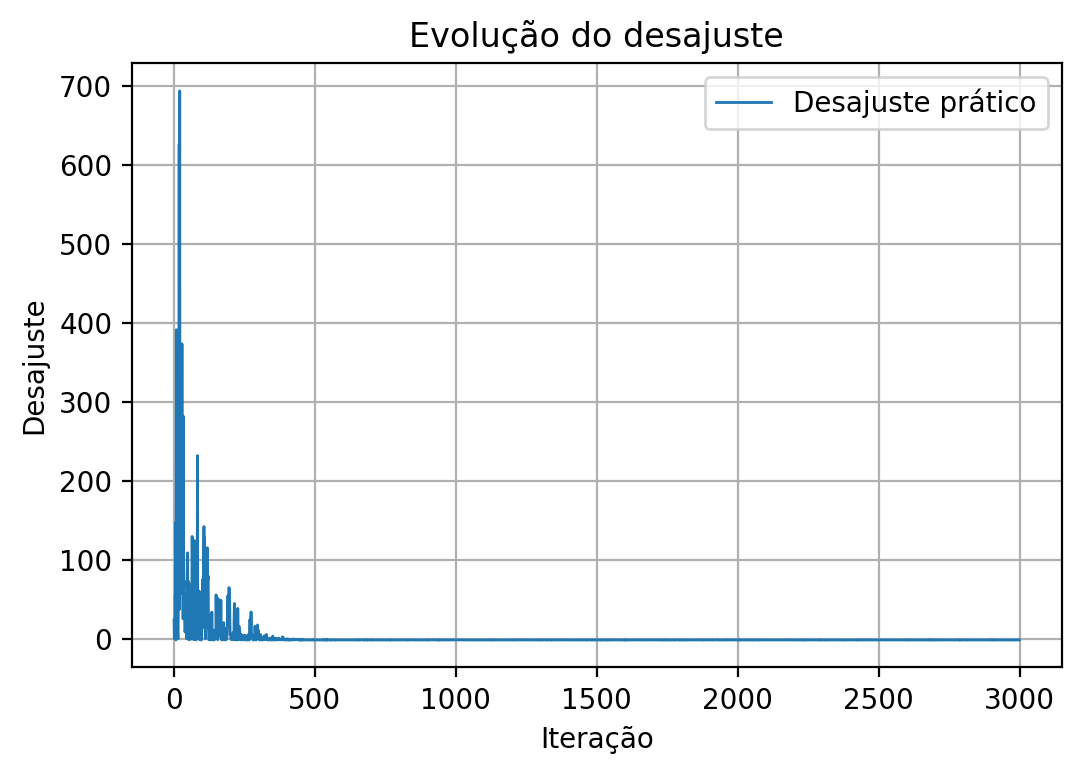

In [101]:
plot_and_save_misajustment(errors_mean4, mse_min_mean4, '../tex/images/lista3_22a3.pdf')
m2 = get_m(errors_mean4, mse_min_mean4)

print('Desajuste prático após convergência:', np.mean(m2[500:]))

In [102]:
def theo_freq_response_problem22():
    h_a = [1, 1]
    h_b = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]

    # wf_ref => Frequência
    # h_resp => Resposta em frequência
    wf_resp, h_resp = signal.freqz(h_b, a=h_a)
    return wf_resp, h_resp

def practice_freq_response_problem22(coeffs):
    wf_resp, h_resp = signal.freqz(coeffs[:, -1])
    return wf_resp, h_resp

def plot_and_savefreq_response_problem22(h_resp_theo, wf_resp_theo, h_resp_practice, wf_resp_practice, save_path):
    fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
    ax.plot(wf_resp_theo, 10 * np.log10(h_resp_theo + 0.1), 'r', label='Teórico')
    ax.plot(wf_resp_practice, 10 * np.log10(h_resp_practice + 0.1), label='Implementado', linestyle='--')
    ax.set_ylabel('Amplitude (dB)')
    ax.set_title('Resposta em frequência')
    ax.set_xlabel('Frequência (rad/amostra)')
    ax.grid(True)
    ax.legend()
    fig.savefig(save_path, bbox_inches = 'tight')

/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


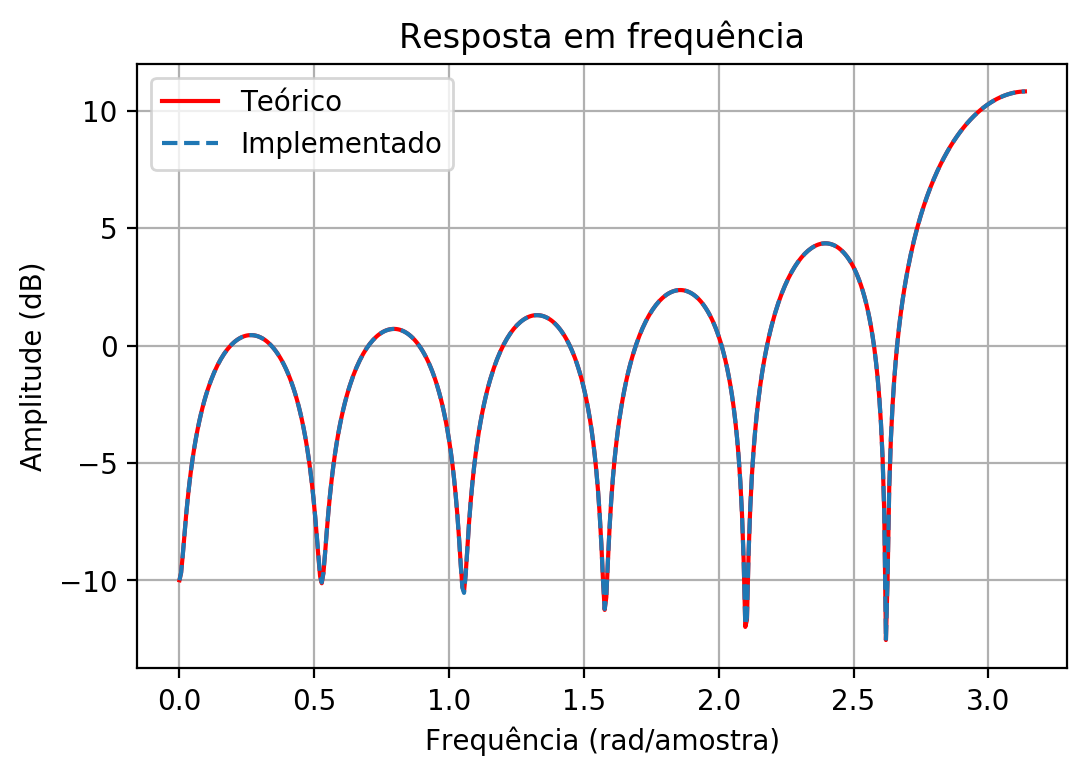

In [103]:
wf_resp_theo, h_resp_theo = theo_freq_response_problem22()
wf_resp_practice, h_resp_practice = practice_freq_response_problem22(coefficients_mean4)

plot_and_savefreq_response_problem22(h_resp_theo, wf_resp_theo, h_resp_practice, wf_resp_practice, '../tex/images/lista3_22a4.pdf')

## Questão 23

Implementação do algoritmo NLMS:

In [113]:
class NLMS:
    """
    Description
    ---------
    Author: Alexandre Henrique da Silva Nunes
    Based on Matlab code by Markus Vinícius Santos Lima available at 
    https://www.mathworks.com/matlabcentral/fileexchange/3582-adaptive-filtering
    
    Implements the REAL NLMS LMS-based algorithm for REAL valued data.
    (Algorithm 4.3 - book: Adaptive Filtering: Algorithms and Practical Implementation, Diniz)
    
    Methods
    ---------
    fit :
        update filter params based on a desired signal and inputs.
    """
    
    def __init__(self, filter_order_num, initial_coefficients):
        """
        Inputs
        -------
        
        filter_order_num : int
                    Order of the FIR filter
        initial_coefficients : numpy array (collumn vector)
                    initial filter coefficients
                
                    
        Variables
        --------
        num_of_coefficients : int
            FIR filter number of coefficients.
        
        errors_vector : numpy array
            FIR error vectors. error_vector[k] represents the output erros at iteration k.
        outputs_vector : numpy array (collumn vector)
            Store the estimated output of each iteration. outputs_vector[k] represents the output erros at iteration k
        coefficients_mtx : numpy array
            Store the estimated coefficients for each iteration. (Coefficients at one iteration are COLUMN vector)
        """
        
        self.filter_order_num = filter_order_num
        self.num_of_coefficients = self.filter_order_num + 1
        
        self.errors_vector = np.array([0], dtype=initial_coefficients.dtype)
        self.outputs_vector = np.array([0], dtype=initial_coefficients.dtype)
        self.coefficients_mtx = np.array(initial_coefficients, dtype=initial_coefficients.dtype)
        
    def fit(self, desired, x, step_n):
        """
        Fit filter parameters to considering desired vector and input x. desired and x must have length K,
        where K is the number of iterations
        
        Inputs
        -------
        
        desired : numpy array (row vector)
            desired signal
        x : numpy array (row vector)
            input signal to feed filter
        step : Convergence (relaxation) factor.
        kargs: Algorithm particular arguments. See each class for more info.
        
        Outputs
        -------
        
        python dic :
            outputs : numpy array (collumn vector)
                Store the estimated output of each iteration. outputs_vector[k] represents the output erros at iteration k
            errors : numpy array (collumn vector)
                FIR error vectors. error_vector[k] represents the output erros at iteration k.
            coefficients_mtx : numpy array
                Store the estimated coefficients for each iteration. (Coefficients at one iteration are COLUMN vector)      
        """
        
        k_max = dim_x(desired)
        self._initialize_vars(k_max)
        
        for k in range(k_max):
            x_k = tapped_x(x, self.num_of_coefficients, k)
            w_k = self.coefficients_mtx[:, k]
            y_k = np.dot(conj(w_k), x_k)
            err_k = desired[k] - y_k
        
            next_w_k = self._coefficients_update_function(w_k, step_n, err_k, x_k)
            
            self._update(err_k, y_k, next_w_k, k)
            
        return {
            'outputs': self.outputs_vector,
            'errors': self.errors_vector,
            'coefficients': self.coefficients_mtx
        }
        
    def _initialize_vars(self, k_max):
        self.errors_vector = np.zeros((k_max, 1))
        self.outputs_vector = np.zeros((k_max, 1), dtype=self.outputs_vector.dtype)
        
        initial_coefficients = self.coefficients_mtx[:, [0]]
        last_coefficients = np.zeros((self.num_of_coefficients, k_max), dtype=initial_coefficients.dtype)
        self.coefficients_mtx = np.append(initial_coefficients, last_coefficients, axis=1)
    
    def _update(self, err, y, next_w, k):
        self.errors_vector[k, 0] = err
        self.outputs_vector[k, 0] = y
        self.coefficients_mtx[:, k+1] = np.transpose(next_w)        
        
    def _coefficients_update_function(self, w_k, step_n, err_k, x_k):
        gamma = 0.01
        return w_k + step_n * err_k * x_k / (gamma + np.dot(np.transpose(x_k), x_k))

### Item b

Configurando o problema

In [132]:
def generate_uniform_noise(kmax, var_n):
    regular_noise = np.random.uniform(-1, 1, kmax)
    return (regular_noise - regular_noise.mean())/np.sqrt(regular_noise.var()/var_n)

def generate_gaussian_noise(kmax, var_n):
    return np.random.normal(0, np.sqrt(var_n), size=kmax)

def generate_problem_23_x(kmax):
    sigma_nx = 0.5
    nx = generate_uniform_noise(kmax, sigma_nx)
    
    hin_a = [1, -0.9]
    hin_b = [1, 0]
    return signal.lfilter(hin_b, hin_a, nx)

def generate_problem_23_d(kmax, x):
    h_a = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    h_b = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
    
    sigma_n = 1e-3
    n = generate_gaussian_noise(kmax, sigma_n)
    
    d = signal.lfilter(h_b, h_a, x) + n
    
    return d, n

def problem_23_single_ensemble(kmax, step_n):
    x = generate_problem_23_x(kmax)
    d, n = generate_problem_23_d(kmax, x)
    N = 11
    w0 = np.zeros((N+1, 1))
    
    model = NLMS(N, w0)
    result = model.fit(d, x, step_n)
    result['mse_min'] = np.square(n)
    
    return result
    

$\mu_n = 1/2$

In [133]:
kmax = 3000
step_n = 0.5

def perform_problem_23_for_ensembles(kmax, step_n, ensembles):
    outputs_mean = 0
    errors_mean = 0
    coefficients_mean = 0
    mse_min_mean = 0
    
    for i in range(0, ensembles):
        result = problem_23_single_ensemble(kmax, step_n)
        outputs_mean += result['outputs']/ensembles
        errors_mean += result['errors']/ensembles
        coefficients_mean += result['coefficients']/ensembles
        mse_min_mean += result['mse_min']/ensembles
        
    return outputs_mean, errors_mean, coefficients_mean, mse_min_mean

ensembles = 25

outputs_mean5, errors_mean5, coefficients_mean5, mse_min_mean5 = perform_problem_23_for_ensembles(kmax, step_n, ensembles)

In [124]:
def plot_and_save_mse(errors, save_path):
    fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)  
    ax.plot(np.linspace(1, kmax, kmax), 10 * np.log10(np.square(errors)), color='#1f77b4', linewidth=1)
    ax.grid(True)
    ax.set_xlabel('Iteração')
    ax.set_ylabel('MSE aproximado (dB)')
    ax.set_title('Evolução do Erro')
    fig.savefig(save_path, bbox_inches = 'tight')

def plot_and_save_coefficients(coeffs, save_path):
    fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
    for i in range(12):
        index = 12 - i
        ax.plot(np.linspace(1, kmax+1, kmax+1), coeffs[i, :], linewidth=1, label='$w_{%i}$' % index)
    ax.grid(True)
    ax.legend()
    ax.set_xlabel('Iteração')
    ax.set_ylabel('Coeficientes')
    ax.set_title('Evolução dos coeficientes')
    fig.savefig(save_path, bbox_inches = 'tight')

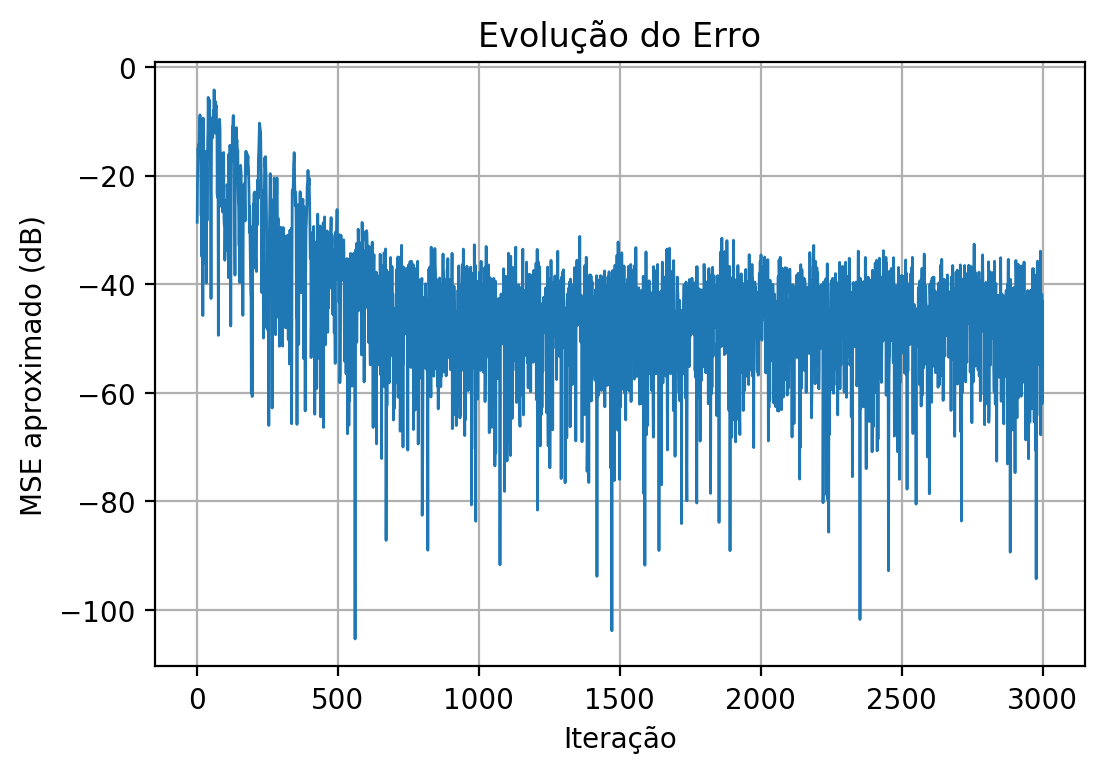

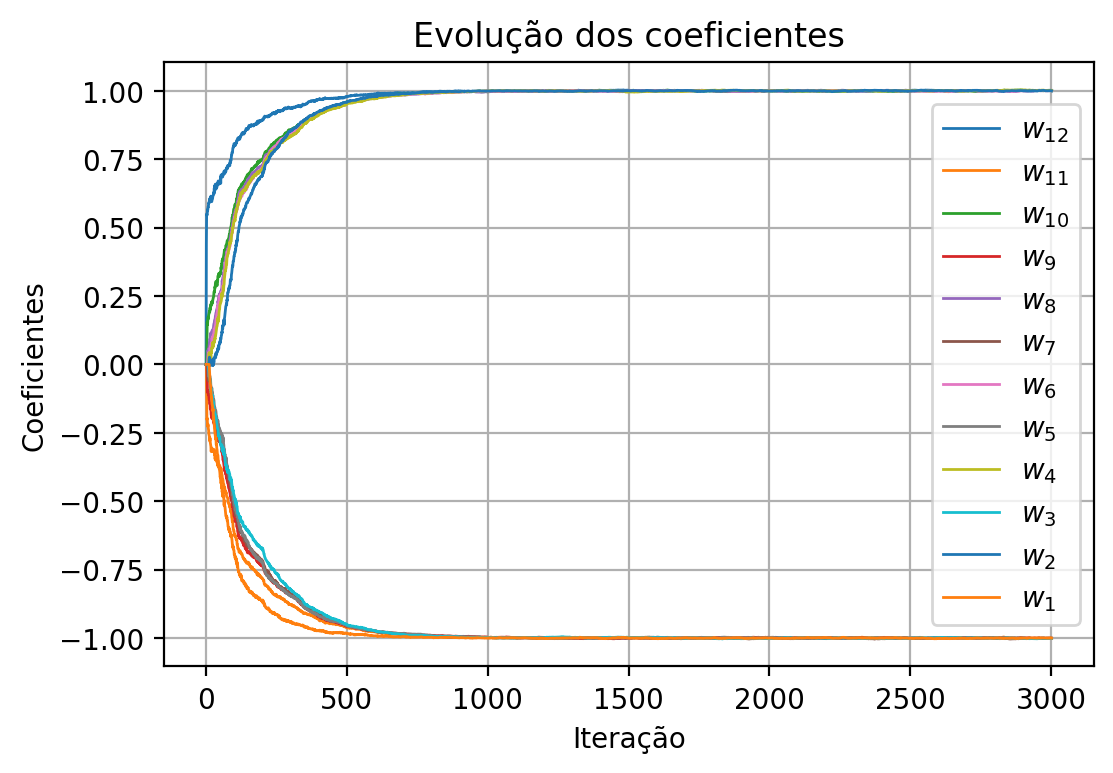

In [125]:
plot_and_save_mse(errors_mean5, '../tex/images/lista3_23a1.pdf')
plot_and_save_coefficients(coefficients_mean5, '../tex/images/lista3_23a2.pdf')

Comparação com o LMS:

In [127]:
class LMS:
    """
    Description
    ---------
    
    Implements the Complex LMS algorithm for COMPLEX valued data.
    (Algorithm 3.2 - book: Adaptive Filtering: Algorithms and Practical Implementation, Diniz)
    
    Author: Alexandre Henrique da Silva Nunes
    Based on Matlab code by Markus Vinícius Santos Lima available at 
    https://www.mathworks.com/matlabcentral/fileexchange/3582-adaptive-filtering
    
    Methods
    ---------
    fit :
        update filter params based on a desired signal and inputs.
    """
    
    def __init__(self, filter_order_num, initial_coefficients):
        """
        Inputs
        -------
        
        filter_order_num : int
                    Order of the FIR filter
        initial_coefficients : numpy array (collumn vector)
                    initial filter coefficients
                
                    
        Variables
        --------
        num_of_coefficients : int
            FIR filter number of coefficients.
        
        errors_vector : numpy array
            FIR error vectors. error_vector[k] represents the output erros at iteration k.
        outputs_vector : numpy array (collumn vector)
            Store the estimated output of each iteration. outputs_vector[k] represents the output erros at iteration k
        coefficients_mtx : numpy array
            Store the estimated coefficients for each iteration. (Coefficients at one iteration are COLUMN vector)
        """
        
        self.filter_order_num = filter_order_num
        self.num_of_coefficients = self.filter_order_num + 1
        
        self.errors_vector = np.array([0], dtype=initial_coefficients.dtype)
        self.outputs_vector = np.array([0], dtype=initial_coefficients.dtype)
        self.coefficients_mtx = np.array(initial_coefficients, dtype=initial_coefficients.dtype)
        
    def fit(self, desired, x, step):
        """
        Fit filter parameters to considering desired vector and input x. desired and x must have length K,
        where K is the number of iterations
        
        Inputs
        -------
        
        desired : numpy array (row vector)
            desired signal
        x : numpy array (row vector)
            input signal to feed filter
        step : Convergence (relaxation) factor.
        
        Outputs
        -------
        
        python dic :
            outputs : numpy array (collumn vector)
                Store the estimated output of each iteration. outputs_vector[k] represents the output erros at iteration k
            errors : numpy array (collumn vector)
                FIR error vectors. error_vector[k] represents the output erros at iteration k.
            coefficients_mtx : numpy array
                Store the estimated coefficients for each iteration. (Coefficients at one iteration are COLUMN vector)      
        """
        
        k_max = self._dim(desired)
        self._initialize_vars(k_max)
        
        for k in range(k_max):
            x_k = LMS.tapped_x(x, self.num_of_coefficients, k)
            w_k = self.coefficients_mtx[:, k]
            y_k = np.dot(LMS._conj(w_k), x_k)
            err_k = desired[k] - y_k
        
            next_w_k = w_k + step * LMS._conj(err_k) * x_k
            
            self._update(err_k, y_k, next_w_k, k)
            
        return {
            'outputs': self.outputs_vector,
            'errors': self.errors_vector,
            'coefficients': self.coefficients_mtx
        }
        
    def _initialize_vars(self, k_max):
        self.errors_vector = np.zeros((k_max, 1))
        self.outputs_vector = np.zeros((k_max, 1), dtype=self.outputs_vector.dtype)
        
        initial_coefficients = self.coefficients_mtx[:, [0]]
        last_coefficients = np.zeros((self.num_of_coefficients, k_max), dtype=initial_coefficients.dtype)
        self.coefficients_mtx = np.append(initial_coefficients, last_coefficients, axis=1)
    
    def _update(self, err, y, next_w, k):
        self.errors_vector[k, 0] = err
        self.outputs_vector[k, 0] = y
        self.coefficients_mtx[:, k+1] = np.transpose(next_w)
    
    @staticmethod
    def tapped_x(x, window, k):
        prefixed_input = LMS._range_x(x, k-window+1, k+1)
        return prefixed_input[::-1]
    
    @staticmethod
    def _x(x, index):
        if index < 0:
            if x.dtype == complex: return complex(0, 0)
            return 0;
        return x[index]
    
    # Improve source code regularity
    @staticmethod
    def _range_x(x, start, length):
        sub_x = [LMS._x(x, start)]
        for it in range(start+1, length):
            sub_x = np.append(sub_x, LMS._x(x, it))
        return sub_x
    
    @staticmethod
    def _dim(vec):
        return vec.shape[0]
    
    @staticmethod
    def _conj(vec):
        return np.conjugate(vec)

In [128]:
step_n = 0.5
step = step_n / (2 * trR * 2)

print('Passo utilizado: ', step)

Passo utilizado:  0.003958201393286891


In [129]:
def problem_23_single_ensemble_LMS(kmax, step):
    x = generate_problem_23_x(kmax)
    d, n = generate_problem_23_d(kmax, x)
    N = 11
    w0 = np.zeros((N+1, 1))
    
    model = LMS(N, w0)
    result = model.fit(d, x, step)
    result['mse_min'] = np.square(n)
    
    return result

In [130]:
kmax = 3000

def perform_problem_23_for_ensembles_LMS(kmax, step, ensembles):
    outputs_mean = 0
    errors_mean = 0
    coefficients_mean = 0
    mse_min_mean = 0
    
    for i in range(0, ensembles):
        result = problem_23_single_ensemble_LMS(kmax, step)
        outputs_mean += result['outputs']/ensembles
        errors_mean += result['errors']/ensembles
        coefficients_mean += result['coefficients']/ensembles
        mse_min_mean += result['mse_min']/ensembles
        
    return outputs_mean, errors_mean, coefficients_mean, mse_min_mean

ensembles = 25

outputs_mean6, errors_mean6, coefficients_mean6, mse_min_mean6 = perform_problem_23_for_ensembles_LMS(kmax, step, ensembles)

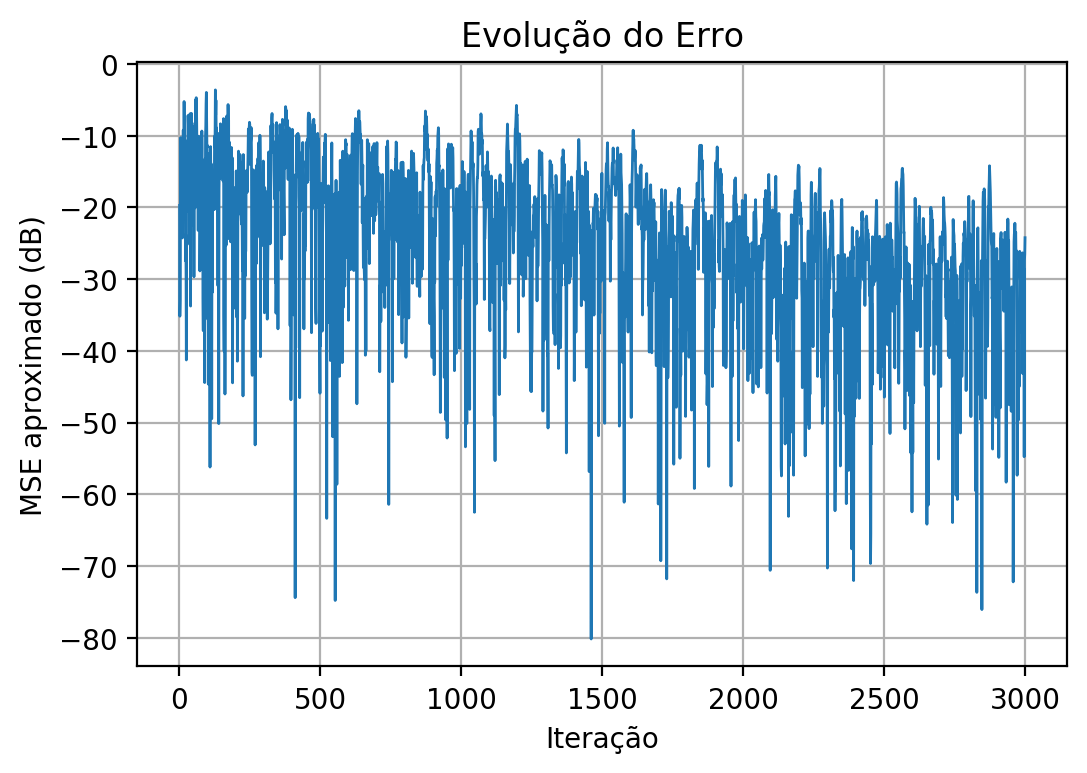

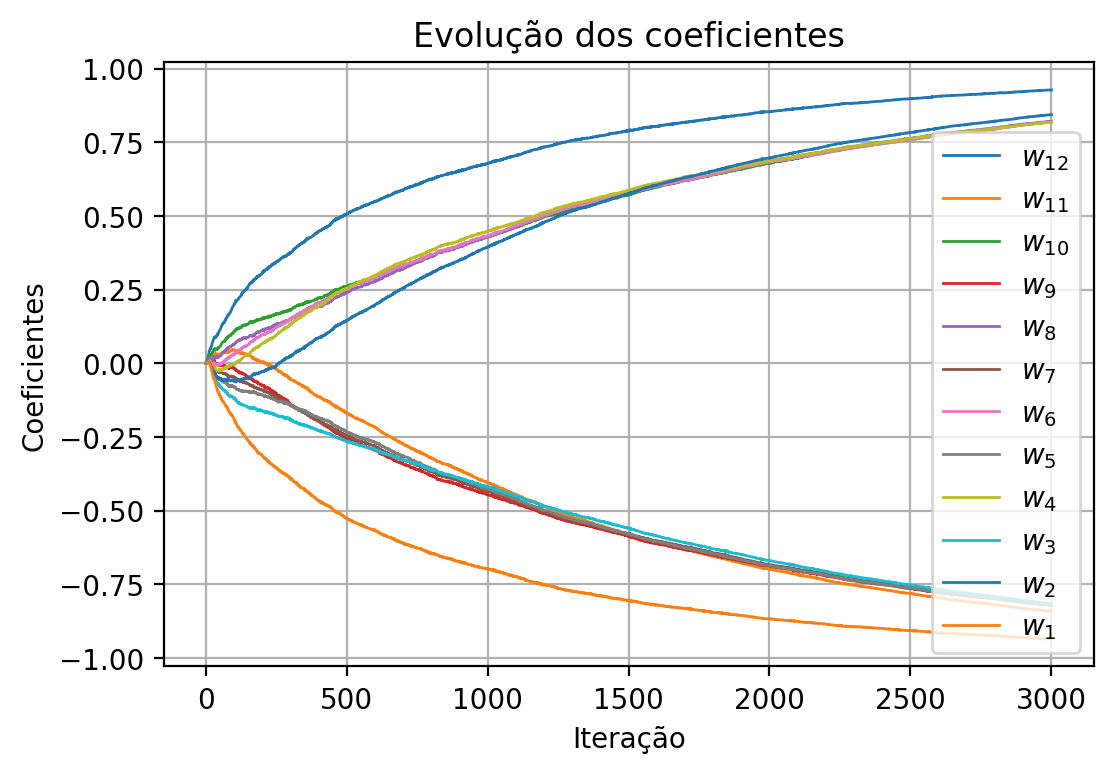

In [131]:
plot_and_save_mse(errors_mean6, '../tex/images/lista3_23a3.pdf')
plot_and_save_coefficients(coefficients_mean6, '../tex/images/lista3_23a4.pdf')

$\mu_n = 1/5$

In [145]:
kmax = 3000
step_n = 0.2
ensembles = 25

outputs_mean7, errors_mean7, coefficients_mean7, mse_min_mean7 = perform_problem_23_for_ensembles(kmax, step_n, ensembles)

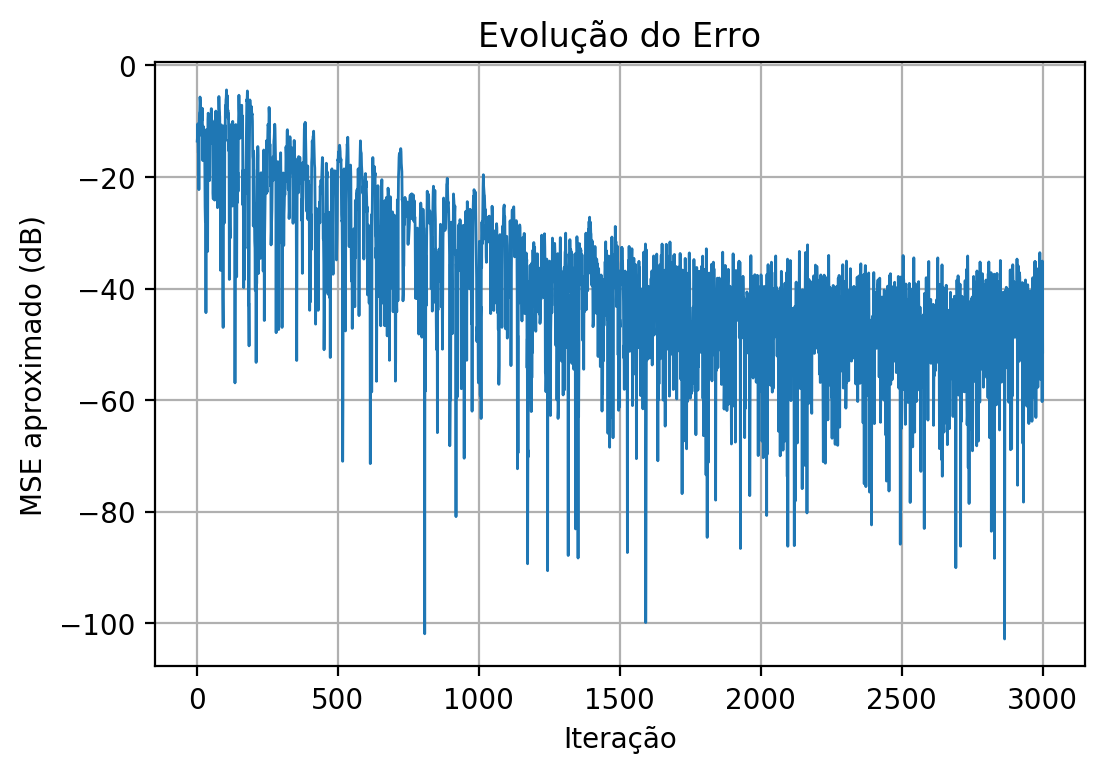

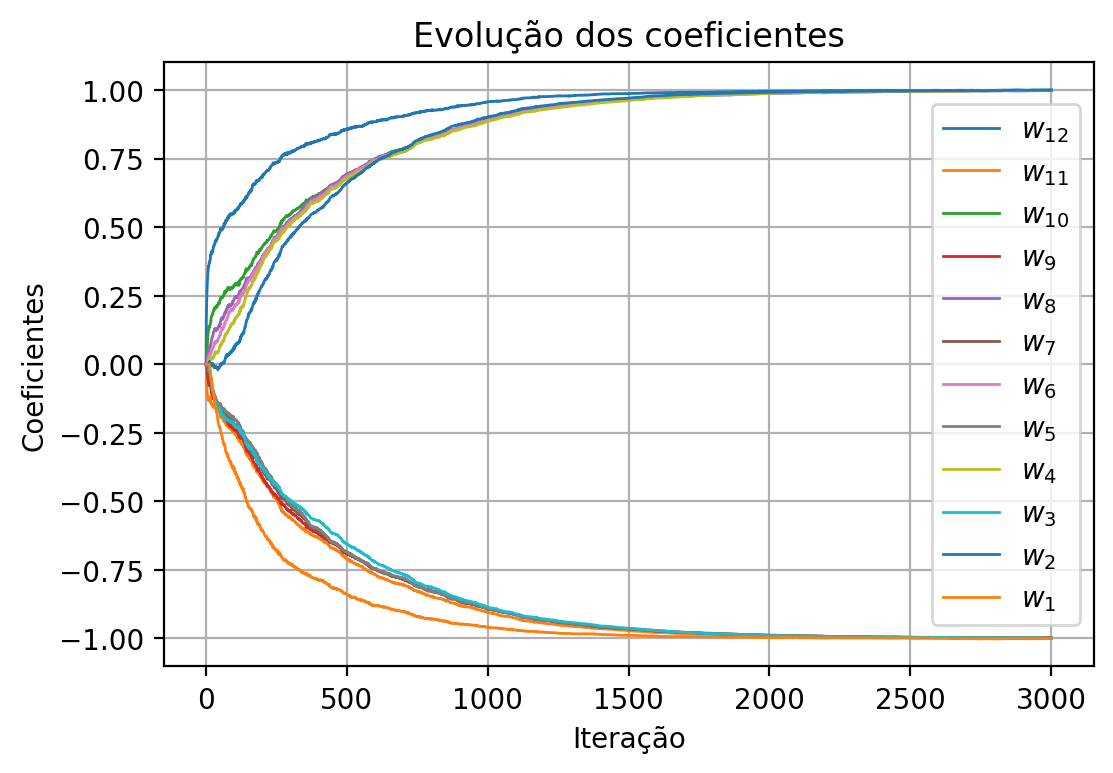

In [146]:
plot_and_save_mse(errors_mean7, '../tex/images/lista3_23a5.pdf')
plot_and_save_coefficients(coefficients_mean7, '../tex/images/lista3_23a6.pdf')

$\mu_n = 1/10$

In [143]:
kmax = 5000
step_n = 0.1
ensembles = 25

outputs_mean8, errors_mean8, coefficients_mean8, mse_min_mean8 = perform_problem_23_for_ensembles(kmax, step_n, ensembles)

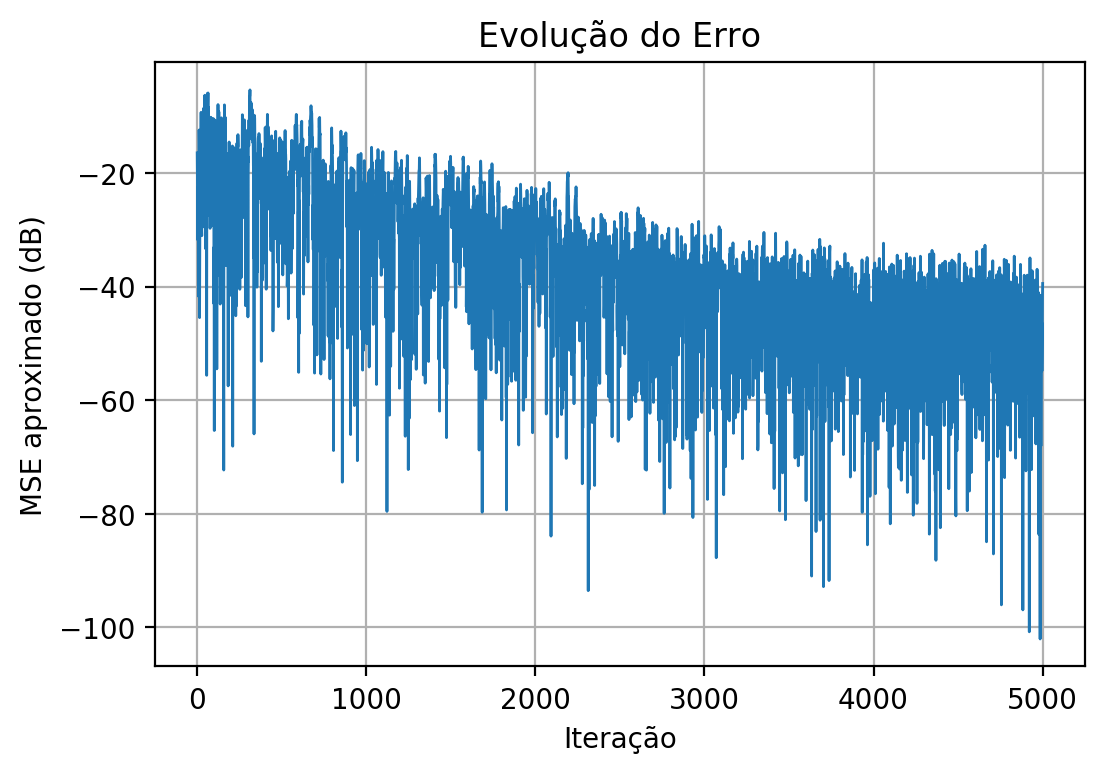

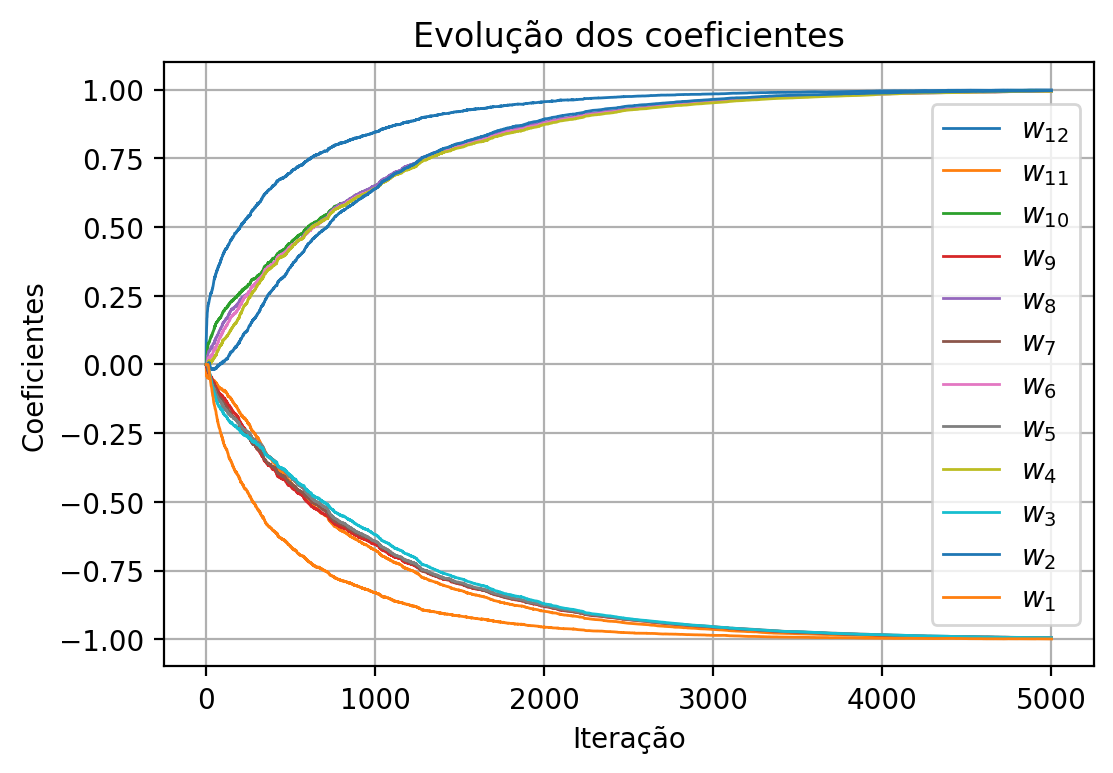

In [144]:
plot_and_save_mse(errors_mean8, '../tex/images/lista3_23a7.pdf')
plot_and_save_coefficients(coefficients_mean8, '../tex/images/lista3_23a8.pdf')

### Item c

In [149]:
def get_m_theo_n(step_n):
    N = 11
    sigma_n = 1e-3
    xi_min = sigma_n
    trR = tr_R_problem_8(N)
    
    return step_n * np.sqrt(math.pi/(2*xi_min)) * trR / (trR * 2)

Para $\mu_n= 1/2$:

In [158]:
step_n = 0.5
m_theo6 = get_m_theo_n(step_n)
print('M teórico: ', m_theo6)

M teórico:  9.908318244015026


In [151]:
def get_m(errors, mse_min):
    mse = np.square(errors)
    m = np.zeros(mse.shape)
    for k in range(m.shape[0]):
        m[k] = (mse[k] - mse_min[k])/(mse_min[k])
    return m

def plot_and_save_misajustment(errors, mse_min, m_theo, save_path):
    fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
    m = get_m(errors, mse_min)
    
    ax.plot(np.linspace(1, kmax, kmax), m, color='#1f77b4', linewidth=1, label='Desajuste prático')
    ax.plot(np.linspace(1, kmax, kmax), m_theo*np.ones(kmax), color='#ff7f0e', linewidth=1, label='Desajuste Teórico (%0.2f)' % m_theo)
    ax.grid(True)
    ax.legend()
    ax.set_xlabel('Iteração')
    ax.set_ylabel('Desajuste')
    ax.set_title('Evolução do desajuste')
    fig.savefig(save_path, bbox_inches = 'tight')

Desajuste prático após convergência: 9.54812508531269


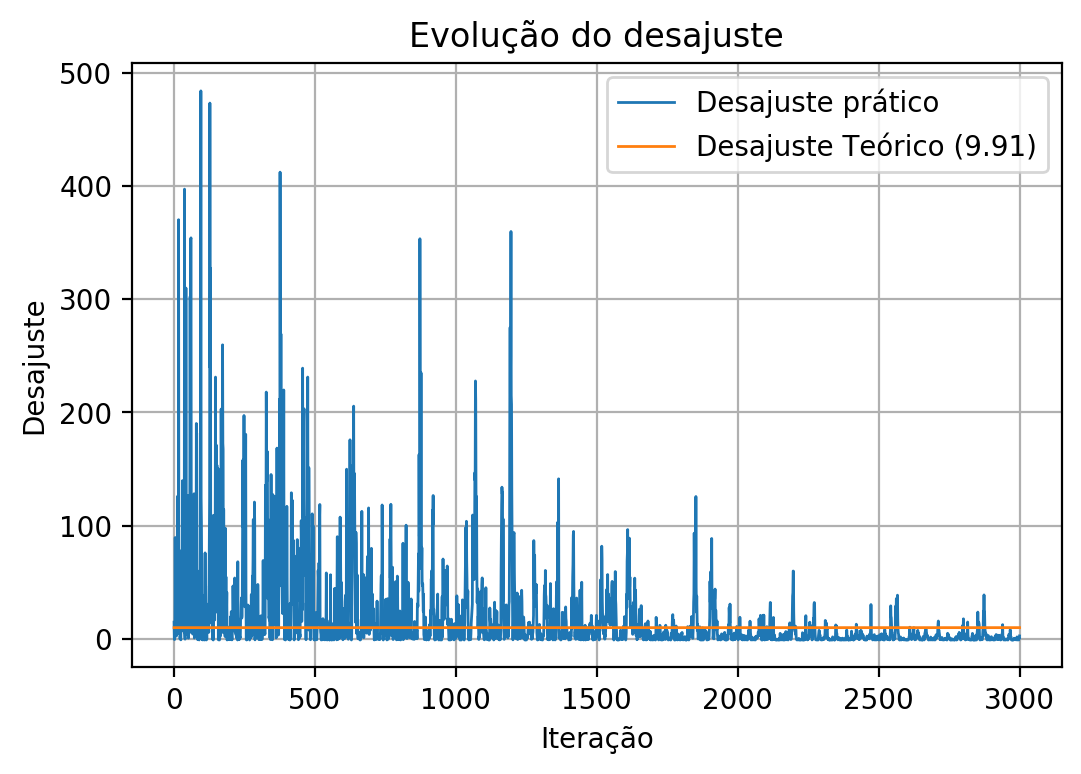

In [154]:
plot_and_save_misajustment(errors_mean6, mse_min_mean6, m_theo6, '../tex/images/lista3_23a9.pdf')
m = get_m(errors_mean6, mse_min_mean6)

print('Desajuste prático após convergência:', np.mean(m[1000:]))

Para $\mu = \mu_{max}/5$:

In [159]:
step_n = 0.2
m_theo7 = get_m_theo_n(step_n)
print('M teórico: ', m_theo7)

M teórico:  3.9633272976060105


Desajuste prático após convergência: -0.9480544046354705


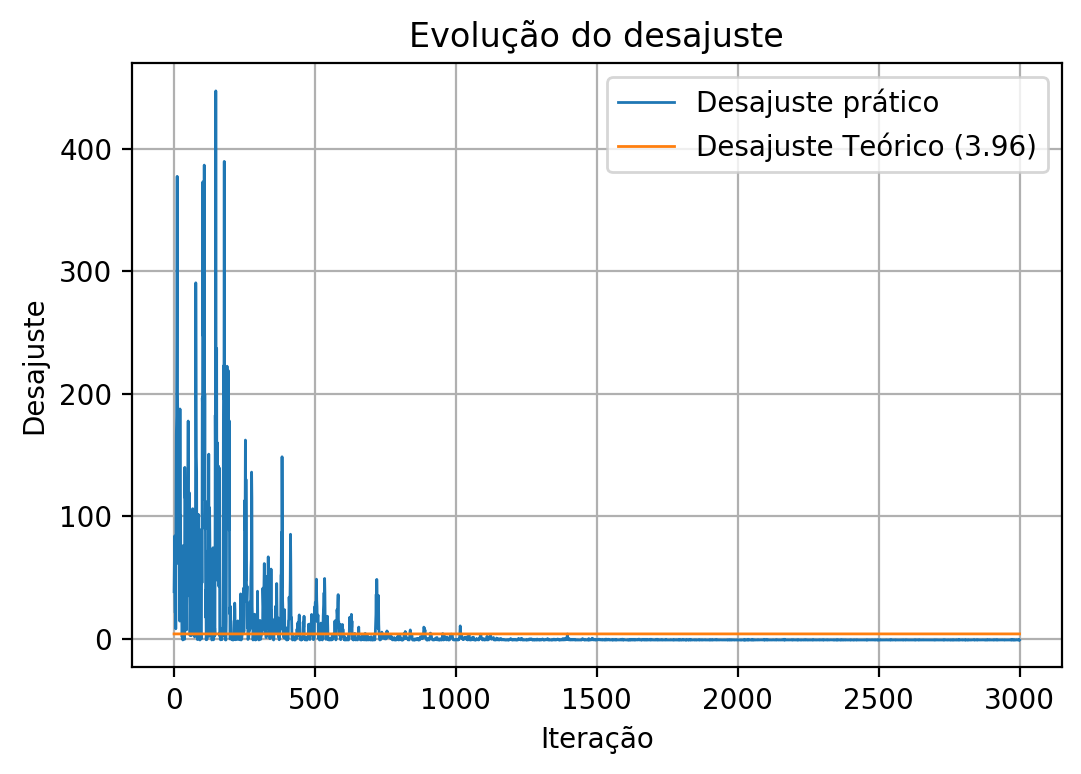

In [166]:
plot_and_save_misajustment(errors_mean7, mse_min_mean7, m_theo7, '../tex/images/lista3_23a10.pdf')
m = get_m(errors_mean7, mse_min_mean7)

print('Desajuste prático após convergência:', np.mean(m[2000:]))

In [169]:
step_n = 0.1
kmax = 5000
m_theo8 = get_m_theo_n(step_n)
print('M teórico: ', m_theo8)

M teórico:  1.9816636488030053


Desajuste prático após convergência: -0.8841534710656666


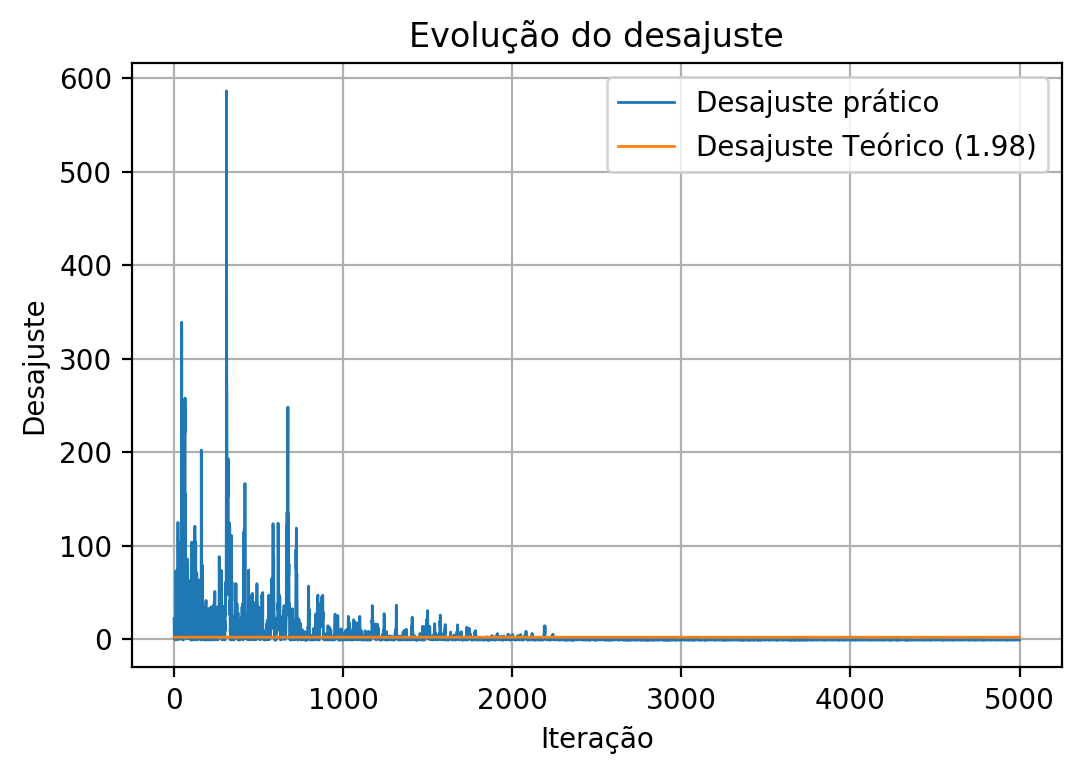

In [171]:
plot_and_save_misajustment(errors_mean8, mse_min_mean8, m_theo8, '../tex/images/lista3_23a11.pdf')
m = get_m(errors_mean8, mse_min_mean8)

print('Desajuste prático após convergência:', np.mean(m[2500:]))

### Item d

Para $\mu = 1/2$:

In [172]:
def theo_freq_response_problem23():
    h_a = [1, 1]
    h_b = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]

    # wf_ref => Frequência
    # h_resp => Resposta em frequência
    wf_resp, h_resp = signal.freqz(h_b, a=h_a)
    return wf_resp, h_resp

def practice_freq_response_problem23(coeffs):
    wf_resp, h_resp = signal.freqz(coeffs[:, -1])
    return wf_resp, h_resp

def plot_and_savefreq_response_problem23(h_resp_theo, wf_resp_theo, h_resp_practice, wf_resp_practice, save_path):
    fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
    ax.plot(wf_resp_theo, 10 * np.log10(h_resp_theo + 0.1), 'r', label='Teórico')
    ax.plot(wf_resp_practice, 10 * np.log10(h_resp_practice + 0.1), label='Implementado', linestyle='--')
    ax.set_ylabel('Amplitude (dB)')
    ax.set_title('Resposta em frequência')
    ax.set_xlabel('Frequência (rad/amostra)')
    ax.grid(True)
    ax.legend()
    fig.savefig(save_path, bbox_inches = 'tight')

/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


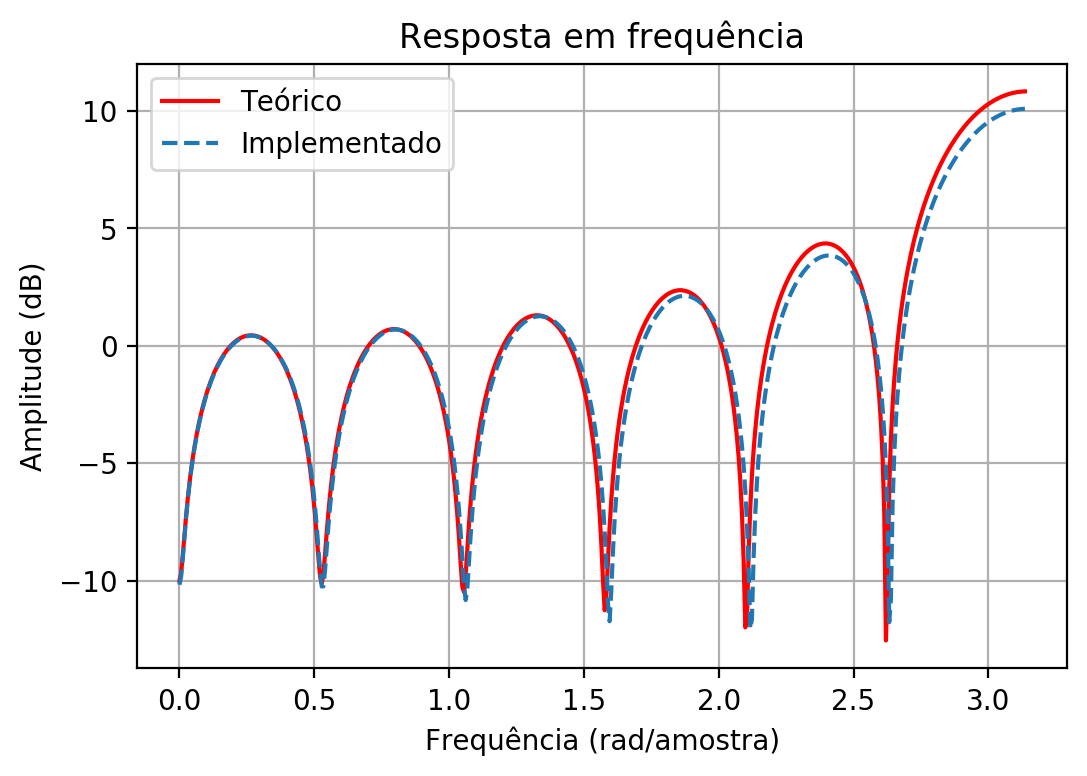

In [173]:
wf_resp_theo, h_resp_theo = theo_freq_response_problem23()
wf_resp_practice, h_resp_practice = practice_freq_response_problem23(coefficients_mean6)

plot_and_savefreq_response_problem23(h_resp_theo, wf_resp_theo, h_resp_practice, wf_resp_practice, '../tex/images/lista3_23a12.pdf')

Para $\mu = 1/5$:

/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


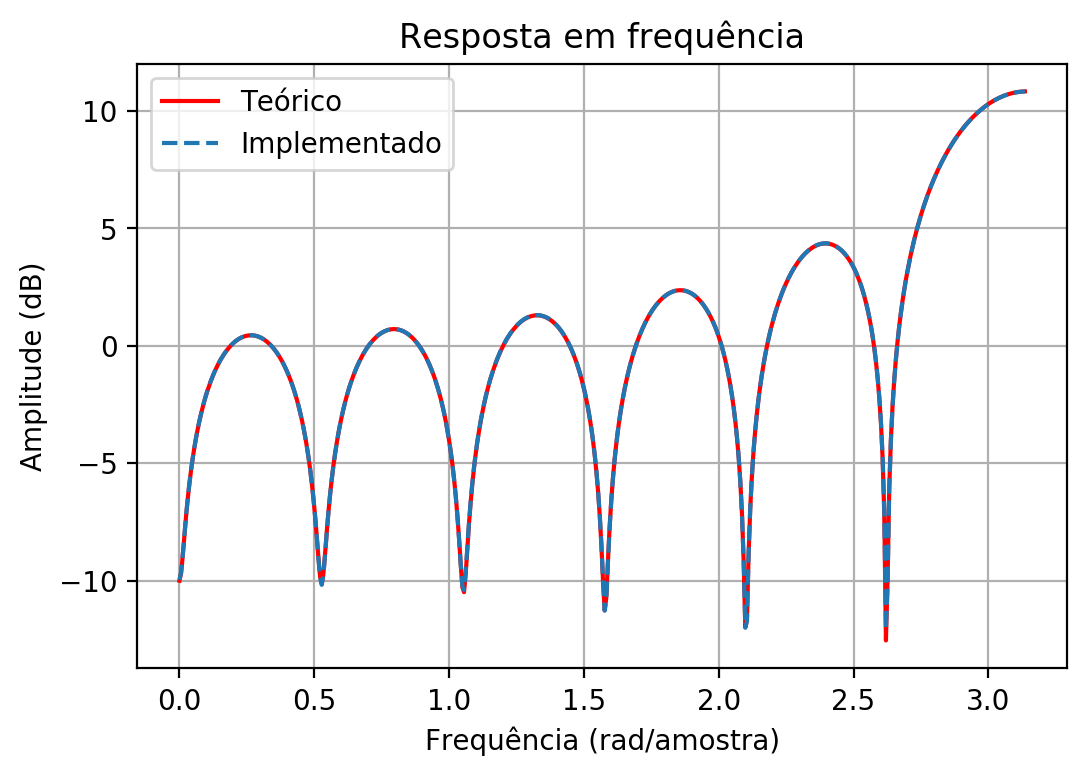

In [174]:
wf_resp_theo, h_resp_theo = theo_freq_response_problem23()
wf_resp_practice, h_resp_practice = practice_freq_response_problem23(coefficients_mean7)

plot_and_savefreq_response_problem23(h_resp_theo, wf_resp_theo, h_resp_practice, wf_resp_practice, '../tex/images/lista3_23a13.pdf')

Para $\mu = 1/10$:

/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


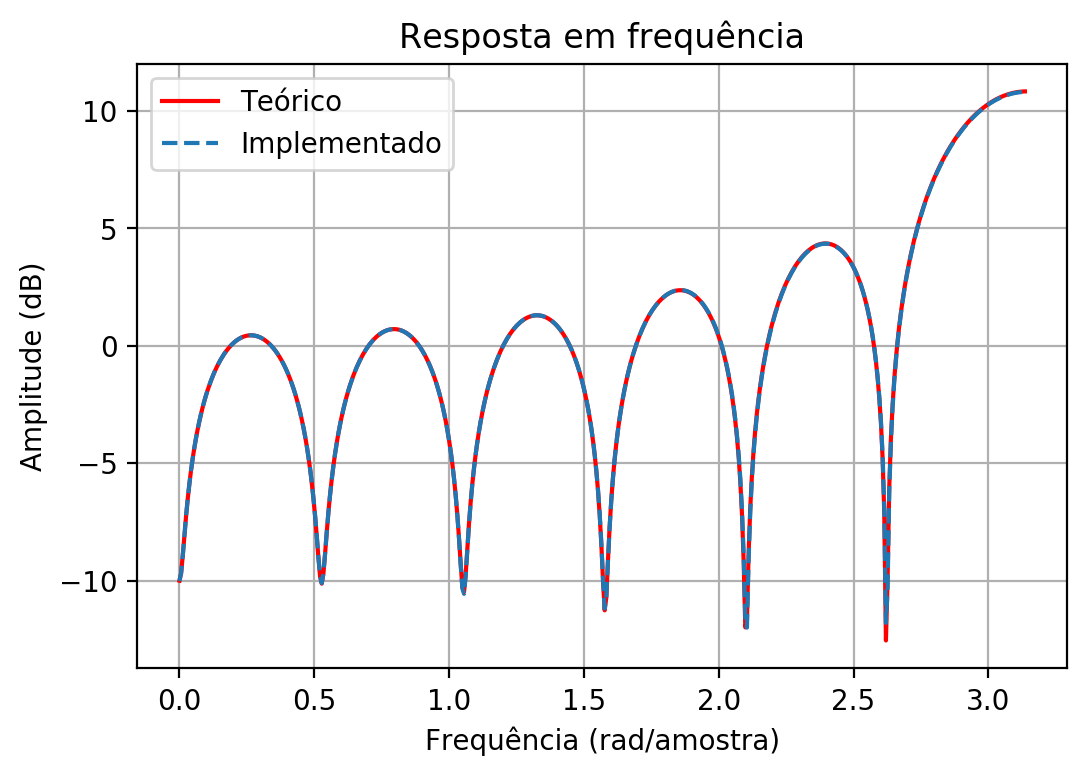

In [175]:
wf_resp_theo, h_resp_theo = theo_freq_response_problem23()
wf_resp_practice, h_resp_practice = practice_freq_response_problem23(coefficients_mean8)

plot_and_savefreq_response_problem23(h_resp_theo, wf_resp_theo, h_resp_practice, wf_resp_practice, '../tex/images/lista3_23a14.pdf')

## Questão 24

Implementação do algoritmo LMS transform domain para DFT 

In [ ]:
class TDomainDFT:
    """
    Description
    ---------
    Author: Alexandre Henrique da Silva Nunes
    Based on Matlab code by Markus Vinícius Santos Lima available at 
    https://www.mathworks.com/matlabcentral/fileexchange/3582-adaptive-filtering
    
    Implements the REAL Transform Domain LMS-based algorithm for DFT transform and REAL valued data.
    (Algorithm 4.4 - book: Adaptive Filtering: Algorithms and Practical Implementation, Diniz)
    
    Methods
    ---------
    fit :
        update filter params based on a desired signal and inputs.
    """
    
    def __init__(self, filter_order_num, initial_coefficients, initial_power):
        """
        Inputs
        -------
        
        filter_order_num : int
                    Order of the FIR filter
        initial_coefficients : numpy array (collumn vector)
                    initial filter coefficients
                
                    
        Variables
        --------
        num_of_coefficients : int
            FIR filter number of coefficients.
        
        errors_vector : numpy array
            FIR error vectors. error_vector[k] represents the output erros at iteration k.
        outputs_vector : numpy array (collumn vector)
            Store the estimated output of each iteration. outputs_vector[k] represents the output erros at iteration k
        coefficients_mtx : numpy array
            Store the estimated coefficients for each iteration. (Coefficients at one iteration are COLUMN vector)
        initial_power : float
            Filter initial power
        """
        
        self.filter_order_num = filter_order_num
        self.num_of_coefficients = self.filter_order_num + 1
        
        self.errors_vector = np.array([0], dtype=initial_coefficients.dtype)
        self.outputs_vector = np.array([0], dtype=initial_coefficients.dtype)
        self.coefficients_mtx = np.array(initial_coefficients, dtype=initial_coefficients.dtype)
        self.initial_power = initial_power
        
    def fit(self, desired, x, step_n, gamma, alpha):
        """
        Fit filter parameters to considering desired vector and input x. desired and x must have length K,
        where K is the number of iterations
        
        Inputs
        -------
        
        desired : numpy array (row vector)
            desired signal
        x : numpy array (row vector)
            input signal to feed filter
        step : float
            convergence (relaxation) factor.
        gamma : float
            small constant to avoid numeric problem for small tapped x.
        alpha : float
            used to estimate eignvalues of Ru. Tipically 0 << alpha < 0.1
        
        Outputs
        -------
        
        python dic :
            outputs : numpy array (collumn vector)
                Store the estimated output of each iteration. outputs_vector[k] represents the output erros at iteration k
            errors : numpy array (collumn vector)
                FIR error vectors. error_vector[k] represents the output erros at iteration k.
            coefficients_mtx : numpy array
                Store the estimated coefficients for each iteration. (Coefficients at one iteration are COLUMN vector)      
        """
        
        k_max = dim_x(desired)
        self._initialize_vars(k_max)
        
        for k in range(k_max):
            x_k = tapped_x(x, self.num_of_coefficients, k)
            
            dft_x_k = np.fft(x_k) 
            power_vec = alpha * 
            
            
            
            w_k = self.coefficients_mtx[:, k]
            y_k = np.dot(conj(w_k), x_k)
            err_k = desired[k] - y_k
        
            next_w_k = self._coefficients_update_function(w_k, step_n, err_k, x_k)
            
            self._update(err_k, y_k, next_w_k, k)
            
        return {
            'outputs': self.outputs_vector,
            'errors': self.errors_vector,
            'coefficients': self.coefficients_mtx
        }
        
    def _initialize_vars(self, k_max):
        self.errors_vector = np.zeros((k_max, 1))
        self.outputs_vector = np.zeros((k_max, 1), dtype=self.outputs_vector.dtype)
        
        initial_coefficients = self.coefficients_mtx[:, [0]]
        last_coefficients = np.zeros((self.num_of_coefficients, k_max), dtype=initial_coefficients.dtype)
        self.coefficients_mtx = np.append(initial_coefficients, last_coefficients, axis=1)
    
    def _update(self, err, y, next_w, k):
        self.errors_vector[k, 0] = err
        self.outputs_vector[k, 0] = y
        self.coefficients_mtx[:, k+1] = np.transpose(next_w)
        
    def _update_power_vec(alpha, )
        
    def _coefficients_update_function(self, w_k, step_n, err_k, x_k):
        gamma = 0.01
        return w_k + step_n * err_k * x_k / (gamma + np.dot(np.transpose(x_k), x_k))